# Import package tools (computational environments)

In [343]:
import requests
import pandas as pd
import re
import nltk
import logging
import time
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from collections import Counter
from fake_useragent import UserAgent
from nltk.tokenize import word_tokenize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rouge import rouge_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import pipeline
from pprintpp import pprint
from urllib import robotparser

# Web Scrape: Beautiful Soup
#### Obtaining job titles and the associated job posting urls from seek for Data Science jobs in Brisbane

In [344]:
def scrape_job_titles_and_urls(url):
    # Initialize robot parser
    rp = robotparser.RobotFileParser()
    rp.set_url("https://www.seek.com.au/robots.txt")
    rp.read()

    # Generate a random User-Agent to avoid detection as a bot
    user_agent = UserAgent()
    headers = {
        'User-Agent': user_agent.random,
        'Referrer': 'https://www.google.com',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    }
    
    # Create list to hold extracted data
    all_job_data = []
    page = 1
    
    # Send request to Seek
    while True:
        params = {'page': page}
        
        # Check if the URL is allowed by robots.txt
        if rp.can_fetch(user_agent.random, url):
            response = requests.get(url, headers=headers, params=params)
            print(response.status_code)
            
            # Inform if there is an access error
            if response.status_code == 403:
                logging.warning("Access denied. Consider adjusting your scraping strategy.")
                return None

            soup = BeautifulSoup(response.text, 'html.parser')
            
            #Sepcified HTML code to obtain desired features
            job_data = soup.find_all('a', class_='_1wkzzau0 _1wkzzauf _1rct8jy2 _1rct8jy4 _1rct8jy7 lnocuo2 _1rct8jy8 _1rct8jyb _1wkzzau0 _1wkzzauf a1msqih', href=True)

            #Obtain features
            job_titles = [job.text.strip() for job in job_data]
            job_urls = [job['href'] for job in job_data]

            print("Job Titles:", job_titles)
            print("Job URLs:", job_urls)

            all_job_data.extend(zip(job_titles, job_urls))

            # Check for the existence of the next page button
            next_button = soup.find('a', {'data-automation': f'page-{page + 1}'})
            if not next_button:
                break  # Exit the loop if there's no next page button
            
            #Go to next page
            page += 1

            # Introduce a delay to mimic human behavior
            time.sleep(10)
        else:
            print(f"URL: {url} is disallowed by robots.txt")
            break

    return all_job_data

# URL for the initial search
initial_url = 'https://www.seek.com.au/data-science-jobs/in-Brisbane-QLD-4000'
job_data = scrape_job_titles_and_urls(initial_url)

for title, url in job_data:
    print(f"Title: {title}, URL: {url}")

200
Job Titles: ['Data Analyst', 'Physics and Science Teacher', 'Graduate Data Scientist', 'Senior Operational Data Scientist', 'Data Lead', 'Data Engineer', 'Data Analyst', 'Data and Analytics Lead', 'Principal HR Data Analyst', 'Data Analyst x 2', 'Senior Data Analyst', 'Data Support Analyst', 'Data Engineer - Investment Resilience & Planning', 'Data and Insights Analyst', 'Analytics and Decision Solutions Regional Lead', 'Data Engineering Team Lead', 'Data Engineer', 'Safety Data & Insights Lead', 'Data Engineer', 'Data Engineer', 'Manager - Data and Analytics', 'Senior Data Analyst']
Job URLs: ['/job/71667227?type=promoted&ref=search-standalone', '/job/71802861?type=promoted&ref=search-standalone', '/job/71958384?type=standout&ref=search-standalone', '/job/72052625?type=standout&ref=search-standalone', '/job/71795985?type=standout&ref=search-standalone', '/job/71836109?type=standard&ref=search-standalone', '/job/71900411?type=standout&ref=search-standalone', '/job/71924011?type=sta

In [345]:
#Convert to Data Frame
job_url_data = pd.DataFrame(job_data)
# Rename columns
job_url_data = job_url_data.rename(columns={0: 'Job Title', 1: 'URL'})

In [348]:
#Save as csv
job_url_data.to_csv('Job_urls.csv', index = False)
display(job_url_data)

Job Title  \
0                                      Data Analyst   
1                                      Data Analyst   
2                                         Data Lead   
3                             Senior Data Scientist   
4                                     Data Engineer   
..                                              ...   
342              Environmental Officers - BNE - Gen   
343  Hazmat & Occupational Hygiene ConsultantHybrid   
344          Senior Geochemist - East CoastFlexible   
345                               Logistics Manager   
346                           Health Representative   

                                                   URL  
0    /job/71826676?type=promoted&ref=search-standalone  
1    /job/71667227?type=promoted&ref=search-standalone  
2    /job/71795985?type=standout&ref=search-standalone  
3    /job/71662757?type=standout&ref=search-standalone  
4    /job/71836109?type=standard&ref=search-standalone  
..                                                 ...  
342  /job/71507589?type=standard&ref=search-standalone  
343  /job/71610316?type=standard&ref=search-standalone  
344  /job/71546073?type=standard&ref=search-standalone  
345  /job/71868849?type=standard&ref=search-standalone  
346  /job/71729288?type=standard&ref=search-standalone  

[347 rows x 2 columns]

In [347]:
#Load csv if needed
job_url_data = pd.read_csv(r"Job_urls.csv")

In [45]:
# Identify and drop rows with duplicate URLs
job_url_data = job_url_data[~job_url_data['URL'].duplicated(keep='first')]

# Display the DataFrame with duplicates removed
display(job_url_data)

#Create list of urls to used for second webscrape of individual jobs
url_list = []
for urls in job_url_data["URL"]:
    url_list.append(urls)

Job Title  \
0                                      Data Analyst   
1                                      Data Analyst   
2                                         Data Lead   
3                             Senior Data Scientist   
4                                     Data Engineer   
..                                              ...   
342              Environmental Officers - BNE - Gen   
343  Hazmat & Occupational Hygiene ConsultantHybrid   
344          Senior Geochemist - East CoastFlexible   
345                               Logistics Manager   
346                           Health Representative   

                                                   URL  
0    /job/71826676?type=promoted&ref=search-standalone  
1    /job/71667227?type=promoted&ref=search-standalone  
2    /job/71795985?type=standout&ref=search-standalone  
3    /job/71662757?type=standout&ref=search-standalone  
4    /job/71836109?type=standard&ref=search-standalone  
..                                                 ...  
342  /job/71507589?type=standard&ref=search-standalone  
343  /job/71610316?type=standard&ref=search-standalone  
344  /job/71546073?type=standard&ref=search-standalone  
345  /job/71868849?type=standard&ref=search-standalone  
346  /job/71729288?type=standard&ref=search-standalone  

[346 rows x 2 columns]

#### Obtaining company name, job location, company department, position type, salary and job description from job posting using urls from first web scraping for Data Science jobs in Brisbane 

In [6]:
# Initialize robot parser
rp = robotparser.RobotFileParser()
rp.set_url("https://www.seek.com.au/robots.txt")
rp.read()

# List to store dictionaries for each iteration
data_list = []

# User agent setup
user_agent = UserAgent()

# Iterate through each job URL
for job_url in job_url_data["URL"]:
    # Create a full URL
    full_url = f'https://www.seek.com.au{job_url}'

    # Check if the URL is allowed by robots.txt
    if rp.can_fetch(user_agent.random, full_url):
        # Headers for the request
        headers = {
            'User-Agent': user_agent.random,
            'Referrer': 'https://www.google.com',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }

        # Send a request to Seek
        response = requests.get(full_url, headers=headers)
        print(f"{full_url}, has been approved for search: {response.status_code}")

        # Pause for a few seconds to avoid overloading the server
        time.sleep(4)

        soup = BeautifulSoup(response.content, 'html.parser')
        
        #Sepcified HTML code to obtain comany features
        try:
            company = soup.find('span', {'data-automation': 'advertiser-name'}).text.strip()
            print(company)
        except AttributeError:
            company = 'None'
            print("Company not found")

        # Extract information from the specific div
        job_info_div = soup.find('div', class_='_1wkzzau0 a1msqi76')

        # Check if job_info_div is not None
        if job_info_div:
            # Find all spans with the specified class within job_info_div
            spans = job_info_div.find_all('span', class_='_1wkzzau0 a1msqi4y a1msqir')

            # Check if spans is not empty before accessing its elements
            if spans:
                # Extract location, department, position type, salary and description from job posting.
                location = spans[0].text.strip()
                print(location)
                department = spans[1].text.strip() if len(spans) > 1 else 'None'
                print(department)
                position_type = spans[2].text.strip() if len(spans) > 2 else 'None'
                print(position_type)

                # Try-except block for handling salary
                try:
                    salary = spans[3].text.strip()
                    print(salary)
                except IndexError:
                    salary = 'None'
                    print("Salary not found")

                # Extract description
                description_element = soup.find('div', {'data-automation': 'jobAdDetails'})
                description = description_element.text.strip() if description_element else 'None'
                print(description)
            else:
                # Handle the case where spans is empty
                print(f"Error: Unable to find spans with the specified class for URL: {full_url}")
                location, department, position_type, salary, description = 'None', 'None', 'None', 'None', 'None'
        else:
            # Handle the case where job_info_div is None
            print(f"Error: Unable to find job_info_div for URL: {full_url}")
            location, department, position_type, salary, description = 'None', 'None', 'None', 'None', 'None'

        # Create a dictionary for the current iteration
        job_data_dict = {
            'URL': full_url,
            'Company': company,
            'Location': location,
            'Department': department,
            'Position Type': position_type,
            'Salary': salary,
            'Description': description,
        }

        # Append the dictionary to the list
        data_list.append(job_data_dict)
    else:
        print(f"URL: {full_url} is disallowed by robots.txt")

# Create a DataFrame from the list of dictionaries
job_data_df = pd.DataFrame(data_list)

# Display the DataFrame
print(job_data_df)

https://www.seek.com.au/job/71826676?type=promoted&ref=search-standalone, has been approved for search: 200
Nexus Support Office
Toowong, Brisbane QLD
Database Development & Administration (Information & Communication Technology)
Contract/Temp
$120,000 + Super per year
Culture and Benefits:At Nexus, caring for our people, patients and employees is at the centre of everything we do. We value our strong team culture and go to great lengths to foster inclusion and engagement across our group. Flexibility and trust are a given. If you thrive on making a positive impact and leading with purpose, we invite you to do your research and check us out. Strong Reward & Recognition programGreat discounts at a large variety of retailersFocus on health and wellbeing (including Fitness Passport)Commitment to employee development and learningDedicated engagement and communication strategy The Nexus Hospitals story:Nexus Hospitals is a leading Australian private hospital group that operates and develops

In [46]:
#View data frame
display(job_data_df)

#View example
display(job_data_df['Description'][5])

URL  \
0    https://www.seek.com.au/job/71826676?type=prom...   
1    https://www.seek.com.au/job/71667227?type=prom...   
2    https://www.seek.com.au/job/71795985?type=stan...   
3    https://www.seek.com.au/job/71662757?type=stan...   
4    https://www.seek.com.au/job/71836109?type=stan...   
..                                                 ...   
341  https://www.seek.com.au/job/71507589?type=stan...   
342  https://www.seek.com.au/job/71610316?type=stan...   
343  https://www.seek.com.au/job/71546073?type=stan...   
344  https://www.seek.com.au/job/71868849?type=stan...   
345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  
0    Culture and Benefits:At Nexus, caring for our ...  
1    We are seeking a dedicated and detail-oriented...  
2    About UsWe’re an innovative and dynamic techno...  
3    Competitive salary package and employee benefi...  
4    A new role has become available for a mid to s...  
..                                                 ...  
341  We are currently tendering for works in Brisba...  
342  What if you could shape built and natural envi...  
343  Join our team of intelligent and collaborative...  
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Logis...  
345  Why do our customers need you?\nWe’re in relen...  

[346 rows x 7 columns]

"The Organisation: \xa0\xa0 Centacare, an Agency of the Catholic Archdiocese of Brisbane, is a values-based organisation dedicated to providing services to the entire community, irrespective of religion, circumstance, ethnicity, economic situation, age, gender, or ability. With a workforce of over 3,000 employees and volunteers, Centacare operates in more than 200 locations, supporting tens of thousands of people each year across various Directorates. \xa0\xa0 The role: \xa0\xa0 We currently have an exciting career progression opportunity for the role of Data Analyst. This role will be a permanent full time position. The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insights for decision-making, ensuring data quality, collaborating with various teams to optimise data usage, and contributing to operational improvements. \xa0\xa0 Key Duties: \xa0\xa0  Collaborate with key stakeholders to ensure

In [83]:
#Look at a few job descriptions to analyse
display(job_data_df['Description'][20])
display(job_data_df['Description'][30])
display(job_data_df['Description'][40])
display(job_data_df['Description'][50])

'About the role\nOur commercial client is looking to engage a Data Engineer on a permanent basis.\nKey Responsibilities\n\nDesign and implement data pipelines that extract data from multiple sources and load it into a central data store.\nWork with stakeholders to understand business requirements and design data models to meet those requirements.\nOptimize and improve existing data pipelines to ensure high performance and reliability.\nDevelop and maintain data quality checks to ensure the accuracy and completeness of data.\nContinuously monitor and maintain data pipelines to ensure they are running smoothly and identify areas for improvement.\nParticipate in code reviews and collaborate with other engineers to maintain high-quality code.\nCreate visualizations with tools like Power BI.\nStay current with industry trends and recommend new tools and technologies to improve the data infrastructure.\nInvolved in discovering workshops and solutions design activities with customers to elici

"Showcase your Data Modelling experience\nContribute to exciting greenfield projects\nFlexible hybrid work environment\n\nWe’re never just satisfied with how things are – because we know how things could be. And it’s our expert Technology team who forge ahead every day to make those ‘what ifs’ a reality.\nThis is an exciting opportunity for an experienced Data Modeller to lead the Data Architecture and Data Modelling efforts within a newly established team at Suncorp. The Senior Data Modeller will oversee the development of data models for Suncorp's Data Warehousing Data Architecture, covering conceptual, logical, and physical models. They will play a pivotal role in ensuring alignment with Data Architecture standards in a specific business domain, particularly in large greenfield projects, and promote these standards across Suncorp.\nThis position requires collaboration with various stakeholders, including Enterprise Architects, Solution Architects, Project Managers, Delivery Managers

'Airswift is an international workforce solutions provider within the energy, process and infrastructure industries. Airswift serves as a strategic partner to our clients, offering a turnkey workforce solution to capture and deliver the top talent needed to complete successful projects by aligning with the unique needs of our clients.\xa0 With over 1000 employees and 9,000 contractors operating in over 70 countries, our geographical reach and pool of talent available is unmatched in the industry and the level of experience, exposure and expertise that the organization has is unparalleled.Our client is seeking a Data Analyst to work within their facilities located in Brisbane, Australia.\xa0The CompanyA Global operator of energy and resources. As a result of internal promotions, they are looking for a Data Analyst (Mid or Senior Level) to add to the Asia Pacific Analytics team which provides leveraged reporting and analytics platforms to this region (primarily) as well as to the global 

"The Opportunity Our client is one of Australia's most successful and progressive consulting companies who have an agile approach to tackling problems and understand that there isn't just one solution to every problem! With a unique approach to problem solving, you will be working directly with customers, capturing additional requirements, and developing intuitive solutions. \xa0 What we are looking forWork directly with clients to gather requirements, design, and test analytics solutionsProvide expert functional knowledge on various MS Power Platform products including Dynamics 365 and applications related to Power Apps - Canvas and Model driven AppsLead large scale projects end to end including project negotiations, budgets and timelines.Support in the design and build of data models to support highly-scalable and cost-efficient data analysis.Apply best practices and be self-motivating to keep up with emerging technologies\xa0 To ensure your success within this role, you will be requ

In [23]:
#Save progress as csv
job_data_df.to_csv('job_data_df.csv', index = False)

In [82]:
#Load csv if needed
job_data_df = pd.read_csv(r'job_data_df.csv')

In [47]:
#Reset index just to ensure the index is aligned before merging
job_url_data = job_url_data.reset_index()
job_data_df = job_data_df.reset_index()

In [48]:
#Analyse datasets before merging
print(job_url_data.shape)
display(job_url_data.head())
print(job_data_df.shape)
display(job_data_df.head())

(346, 3)


index              Job Title  \
0      0           Data Analyst   
1      1           Data Analyst   
2      2              Data Lead   
3      3  Senior Data Scientist   
4      4          Data Engineer   

                                                 URL  
0  /job/71826676?type=promoted&ref=search-standalone  
1  /job/71667227?type=promoted&ref=search-standalone  
2  /job/71795985?type=standout&ref=search-standalone  
3  /job/71662757?type=standout&ref=search-standalone  
4  /job/71836109?type=standard&ref=search-standalone

(346, 8)


index                                                URL  \
0      0  https://www.seek.com.au/job/71826676?type=prom...   
1      1  https://www.seek.com.au/job/71667227?type=prom...   
2      2  https://www.seek.com.au/job/71795985?type=stan...   
3      3  https://www.seek.com.au/job/71662757?type=stan...   
4      4  https://www.seek.com.au/job/71836109?type=stan...   

                                            Company  \
0                              Nexus Support Office   
1  Fleet Safety Services P/L TAS Minecorp Australia   
2                             Jumbo Interactive Ltd   
3                           Queensland Country Bank   
4                                   Humanised Group   

                     Location  \
0       Toowong, Brisbane QLD   
1  Acacia Ridge, Brisbane QLD   
2                Brisbane QLD   
3                Brisbane QLD   
4                Brisbane QLD   

                                          Department  Position Type  \
0  Database Development & Administration (Informa...  Contract/Temp   
1  Business/Systems Analysts (Information & Commu...      Full time   
2  Team Leaders (Information & Communication Tech...      Full time   
3                       Other (Science & Technology)      Full time   
4  Database Development & Administration (Informa...      Full time   

                      Salary  \
0  $120,000 + Super per year   
1                        NaN   
2                        NaN   
3                        NaN   
4              $145,000 base   

                                         Description  
0  Culture and Benefits:At Nexus, caring for our ...  
1  We are seeking a dedicated and detail-oriented...  
2  About UsWe’re an innovative and dynamic techno...  
3  Competitive salary package and employee benefi...  
4  A new role has become available for a mid to s...

In [49]:
# Merge data on left join
job_df = pd.merge(job_data_df, job_url_data[['index', 'Job Title']], on='index', how='left')

# Print the result
display(job_df)

index                                                URL  \
0        0  https://www.seek.com.au/job/71826676?type=prom...   
1        1  https://www.seek.com.au/job/71667227?type=prom...   
2        2  https://www.seek.com.au/job/71795985?type=stan...   
3        3  https://www.seek.com.au/job/71662757?type=stan...   
4        4  https://www.seek.com.au/job/71836109?type=stan...   
..     ...                                                ...   
341    341  https://www.seek.com.au/job/71507589?type=stan...   
342    342  https://www.seek.com.au/job/71610316?type=stan...   
343    343  https://www.seek.com.au/job/71546073?type=stan...   
344    344  https://www.seek.com.au/job/71868849?type=stan...   
345    345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  \
0    Culture and Benefits:At Nexus, caring for our ...   
1    We are seeking a dedicated and detail-oriented...   
2    About UsWe’re an innovative and dynamic techno...   
3    Competitive salary package and employee benefi...   
4    A new role has become available for a mid to s...   
..                                                 ...   
341  We are currently tendering for works in Brisba...   
342  What if you could shape built and natural envi...   
343  Join our team of intelligent and collaborative...   
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Lo

In [50]:
#Replace 'None' input with NaN
job_df["Description"].replace('None', pd.NA, inplace=True)

#Drop Description
job_df.dropna(subset = ["Description"], inplace=True)

#Remove and any url duplicates if there are any
job_df['URL'].duplicated().sum() #0 duplicates

#Reset the index
job_df.reset_index()

display(job_df) #0 rows dropped due to missing description values

index                                                URL  \
0        0  https://www.seek.com.au/job/71826676?type=prom...   
1        1  https://www.seek.com.au/job/71667227?type=prom...   
2        2  https://www.seek.com.au/job/71795985?type=stan...   
3        3  https://www.seek.com.au/job/71662757?type=stan...   
4        4  https://www.seek.com.au/job/71836109?type=stan...   
..     ...                                                ...   
341    341  https://www.seek.com.au/job/71507589?type=stan...   
342    342  https://www.seek.com.au/job/71610316?type=stan...   
343    343  https://www.seek.com.au/job/71546073?type=stan...   
344    344  https://www.seek.com.au/job/71868849?type=stan...   
345    345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  \
0    Culture and Benefits:At Nexus, caring for our ...   
1    We are seeking a dedicated and detail-oriented...   
2    About UsWe’re an innovative and dynamic techno...   
3    Competitive salary package and employee benefi...   
4    A new role has become available for a mid to s...   
..                                                 ...   
341  We are currently tendering for works in Brisba...   
342  What if you could shape built and natural envi...   
343  Join our team of intelligent and collaborative...   
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Lo

In [51]:
#Save progress
job_df.to_csv('job_df.csv', index = False)

# Exploratory Data Analysis (EDA) of sample (feature) distributions
#### Company

In [312]:
#Company variable
job_df['Company'].unique()

array(['Nexus Support Office',
       'Fleet Safety Services P/L TAS Minecorp Australia',
       'Jumbo Interactive Ltd', 'Queensland Country Bank',
       'Humanised Group', 'Centacare',
       'Department of Health - Queensland', 'Australian Retirement Trust',
       'Wesley Mission Queensland', 'Hatch Pty Ltd', 'Paxus',
       'Airservices Australia',
       'Department of Employment and Workplace Relations',
       'Orange Sky Australia', 'Queensland University of Technology',
       'P&C Partners Pty Ltd', 'Ramsay Health Care', 'Exclaim IT',
       'GradConnection', 'Villanova College', 'Technology People',
       'Lime Recruitment', 'Queensland Rail', 'MTP Services',
       'Robert Half', 'Private Advertiser', 'Suncorp',
       'Coachwood Information Professionals P/L',
       'Department of Queensland Treasury', 'Troocoo',
       'Peoplebank Australia QLD', 'M&T Resources', 'Protech SEQ',
       'Australian Energy Market Operator (AEMO)',
       'Queensland Building and Construc

In [313]:
#Frequncy count
Company_counts = job_df['Company'].value_counts()
Company_counts_df = Company_counts.reset_index()
Company_counts_df.columns = ['Company', 'Frequency']
display(Company_counts_df[0:11])
display(Company_counts_df[11:16])

Company  Frequency
0          The University of Queensland         15
1   Queensland University of Technology          9
2     Department of Health - Queensland          7
3             WSP Australia Pty Limited          5
4                           Mater Group          5
5                         Hatch Pty Ltd          4
6                               Suncorp          4
7                            Sanofi CHC          3
8                             Rio Tinto          3
9                           Robert Half          3
10                      UnitingCare Qld          3

Company  Frequency
11             NES Fircroft          3
12  Energy Queensland Group          3
13         Virgin Australia          3
14                 Seqwater          3
15                   Worley          3

In [314]:
def frequency_count_visualisation(column, top_n=15, color_palette='viridis', figsize=(10, 6)):
    # Count word frequencies
    word_counts = Counter(column)

    # Get the top N most frequent words
    top_words = word_counts.most_common(top_n)

    # Convert the data to a DataFrame for easier plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

    # Sort the DataFrame in descending order by frequency
    top_words_df = top_words_df.sort_values(by='Frequency', ascending=True)

    # Set a color palette for the bar chart
    colors = sns.color_palette(color_palette, len(top_words_df))

    # Plot the horizontal bar chart
    plt.figure(figsize=figsize)
    bars = plt.barh(top_words_df['Word'], top_words_df['Frequency'], color=colors)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Word Frequency')
    plt.ylabel('Word')

    # Add data labels on the right of the bars
    for bar, label in zip(bars, top_words_df['Frequency']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label,
                 ha='left', va='center', color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()

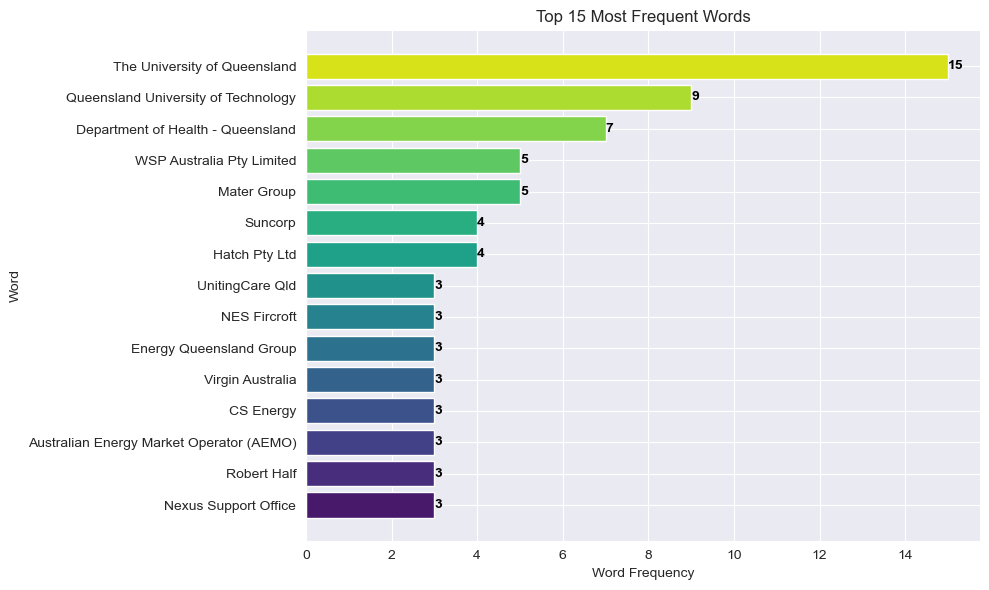

In [315]:
frequency_count_visualisation(job_df['Company'])

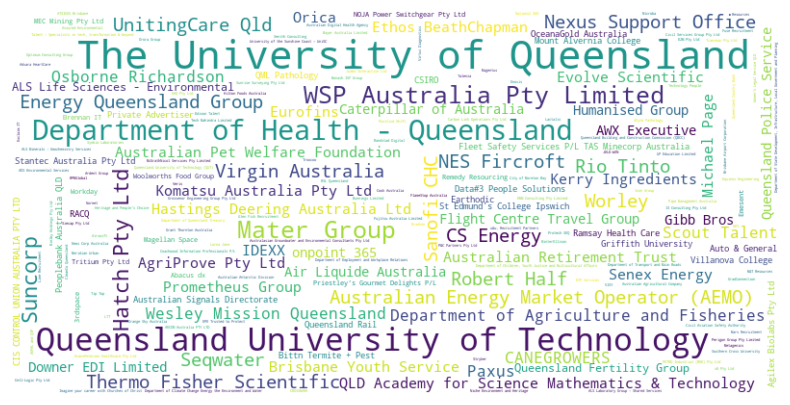

In [317]:
def generate_wordcloud(dataframe, company_column, frequency_column):
    # Convert the DataFrame to a dictionary
    word_dict = dict(zip(dataframe[company_column], dataframe[frequency_column]))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
generate_wordcloud(Company_counts_df, company_column='Company', frequency_column='Frequency')

### Location

In [370]:
#Location variable
job_df['Location'].unique()

array(['Toowong, Brisbane QLD', 'Acacia Ridge, Brisbane QLD',
       'Brisbane QLD', 'Bowen Hills, Brisbane QLD',
       'Chermside, Brisbane QLD', 'Greenslopes, Brisbane QLD',
       'Coorparoo, Brisbane QLD', 'South Brisbane, Brisbane QLD',
       'Fortitude Valley, Brisbane QLD', 'Eagle Farm, Brisbane QLD',
       'West End, Brisbane QLD', 'Kedron, Brisbane QLD',
       'Sinnamon Park, Brisbane QLD', 'Indooroopilly, Brisbane QLD',
       'Newstead, Brisbane QLD', 'St Lucia, Brisbane QLD',
       'Ipswich, Brisbane QLD', 'Eight Mile Plains, Brisbane QLD',
       'Brisbane Airport, Brisbane QLD', 'Annerley, Brisbane QLD',
       'Kelvin Grove, Brisbane QLD', 'Kenmore, Brisbane QLD',
       'Heathwood, Brisbane QLD', 'The Gap, Brisbane QLD',
       'Stapylton, Gold Coast QLD', 'Loganholme, Brisbane QLD',
       'Nathan, Brisbane QLD', 'Springfield, Brisbane QLD',
       'Cornubia, Brisbane QLD', 'Herston, Brisbane QLD',
       'Ormeau, Gold Coast QLD', 'Caboolture, Brisbane QLD',
     

In [128]:
#Frequncy count
Location_counts = job_df['Location'].value_counts()
Location_counts_df = Location_counts.reset_index()
Location_counts_df.columns = ['Location', 'Frequency']
display(Location_counts_df[0:11])
display(Location_counts_df[11:16])

Location  Frequency
0                      Brisbane QLD        188
1      South Brisbane, Brisbane QLD         13
2            Murarrie, Brisbane QLD         10
3            St Lucia, Brisbane QLD          9
4            Newstead, Brisbane QLD          8
5    Fortitude Valley, Brisbane QLD          8
6             Toowong, Brisbane QLD          7
7   Eight Mile Plains, Brisbane QLD          7
8              Kedron, Brisbane QLD          4
9       Indooroopilly, Brisbane QLD          4
10            Ipswich, Brisbane QLD          4

Location  Frequency
11           Wacol, Brisbane QLD          4
12          Milton, Brisbane QLD          4
13         Kenmore, Brisbane QLD          4
14   Woolloongabba, Brisbane QLD          4
15  Coopers Plains, Brisbane QLD          3

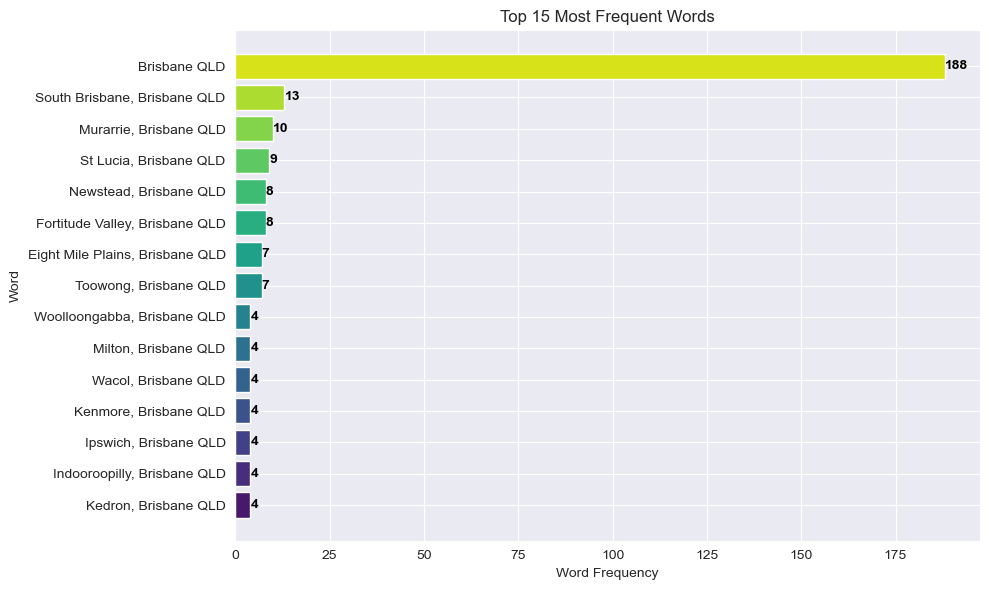

In [122]:
frequency_count_visualisation(job_df['Location'])

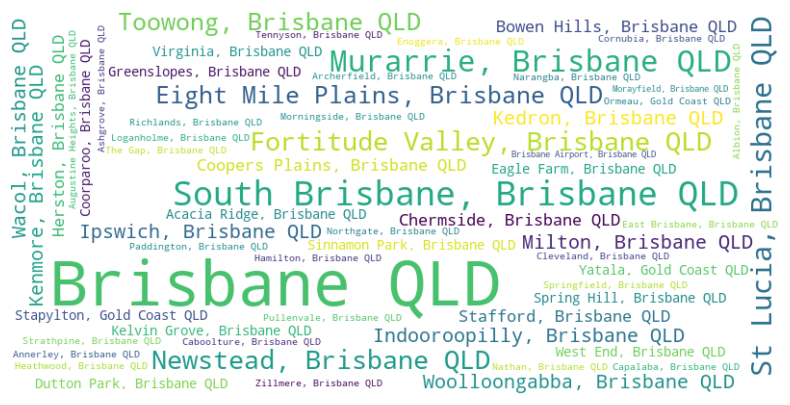

In [320]:
generate_wordcloud(Location_counts_df, company_column='Location', frequency_column='Frequency')

### Department

In [105]:
#Department variable
job_df['Department'].unique()

array(['Database Development & Administration (Information & Communication Technology)',
       'Business/Systems Analysts (Information & Communication Technology)',
       'Team Leaders (Information & Communication Technology)',
       'Other (Science & Technology)',
       'Analysis & Reporting (Banking & Financial Services)Government - State (Government & Defence)',
       'Business/Systems Analysts (Information & Communication Technology)Government - State (Government & Defence)',
       'Engineering - Software (Information & Communication Technology)',
       'Mathematics, Statistics & Information Sciences (Science & Technology)Government - Federal (Government & Defence)',
       'Other, Government - Federal (Government & Defence)',
       'Analysts (Consulting & Strategy)',
       'Research & Fellowships, Other (Education & Training)',
       'Process Engineering (Engineering)',
       'Developers/Programmers (Information & Communication Technology)',
       'Teaching Aides & Spe

In [129]:
#Frequncy count
Department_counts = job_df['Department'].value_counts()
Department_counts_df = Department_counts.reset_index()
Department_counts_df.columns = ['Department', 'Frequency']
display(Department_counts_df[0:11])
display(Department_counts_df[11:16])

Department  Frequency
0   Business/Systems Analysts (Information & Commu...         24
1   Database Development & Administration (Informa...         18
2   Engineering - Software (Information & Communic...         15
3   Laboratory & Technical Services (Science & Tec...         15
4   Environmental, Earth & Geosciences (Science & ...         14
5      Other (Information & Communication Technology)         10
6   Research & Fellowships, Other (Education & Tra...          9
7         Teaching - Secondary (Education & Training)          8
8   Developers/Programmers (Information & Communic...          8
9         Government - Federal (Government & Defence)          7
10  Consultants (Information & Communication Techn...          6

Department  Frequency
11  Agronomy & Farm Services (Farming, Animals & C...          5
12  Business/Systems Analysts (Information & Commu...          5
13                  Process Engineering (Engineering)          4
14                   Analysts (Consulting & Strategy)          4
15  Environment & Sustainability Consulting (Consu...          4

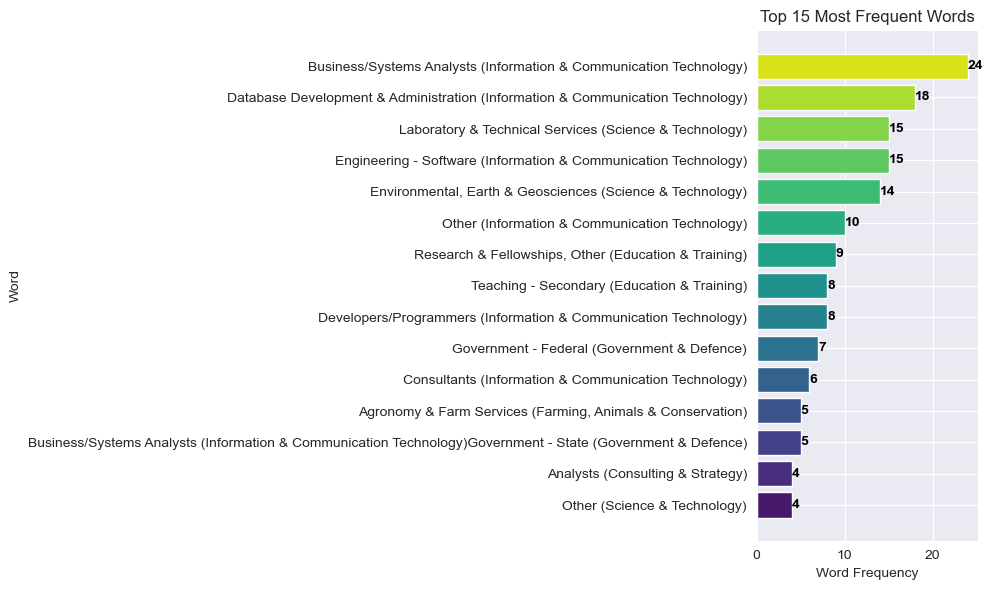

In [123]:
frequency_count_visualisation(job_df['Department'])

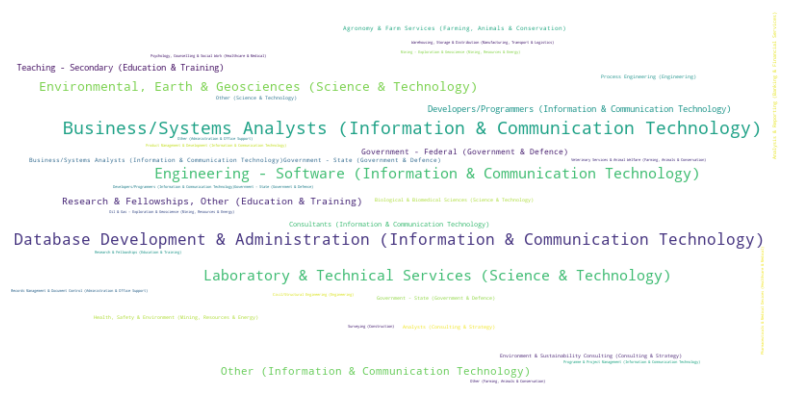

In [321]:
generate_wordcloud(Department_counts_df, company_column='Department', frequency_column='Frequency')

### Position Type

In [324]:
#Position Type variable
job_df['Position Type'].unique()

array(['Contract/Temp', 'Full time', 'Part time', 'Casual/Vacation',
       'Contract/Temp, Casual/Vacation, Full time, Part time',
       'Contract/Temp, Casual/Vacation, Full time',
       'Contract/Temp, Full time', 'Contract/Temp, Casual/Vacation'],
      dtype=object)

In [323]:
#Frequncy count
Position_type_counts = job_df['Position Type'].value_counts()
Position_type_counts_df = Position_type_counts.reset_index()
Position_type_counts_df.columns = ['Position Type', 'Frequency']
display(Position_type_counts_df[0:11])

Position Type  Frequency
0                                          Full time        277
1                                      Contract/Temp         51
2                                          Part time          5
3                                    Casual/Vacation          5
4  Contract/Temp, Casual/Vacation, Full time, Par...          3
5          Contract/Temp, Casual/Vacation, Full time          2
6                           Contract/Temp, Full time          2
7                     Contract/Temp, Casual/Vacation          1

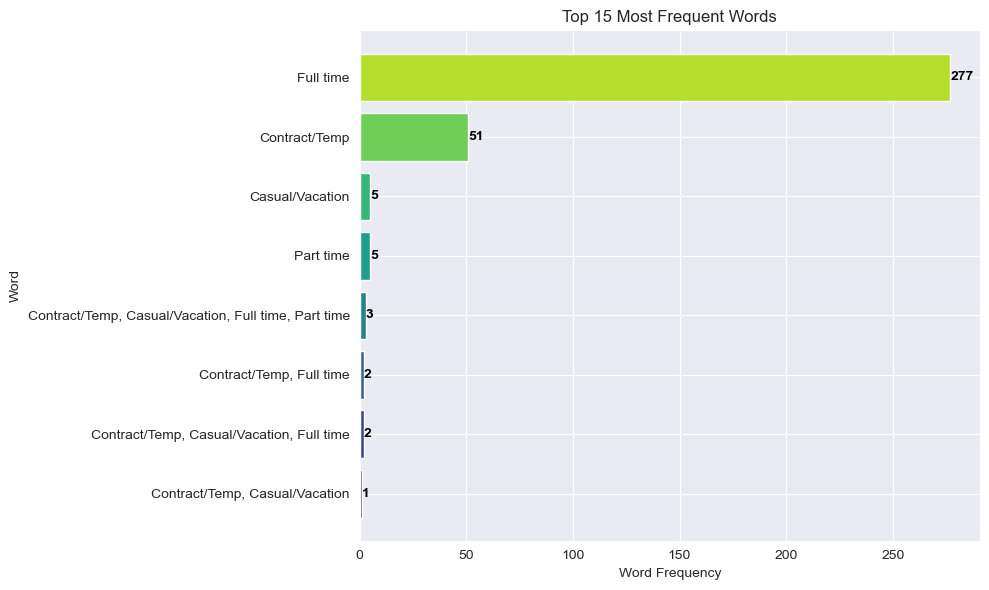

In [325]:
frequency_count_visualisation(job_df['Position Type'])

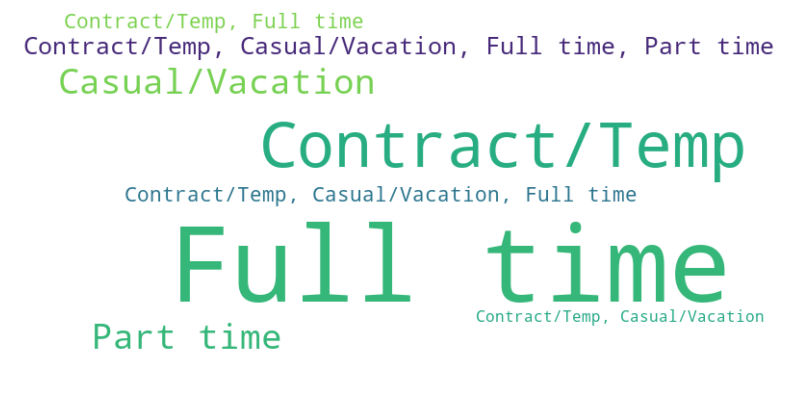

In [327]:
generate_wordcloud(Position_type_counts_df, company_column='Position Type', frequency_column='Frequency')

### Salary

In [113]:
#Salary variable
job_df['Salary'].unique()

array(['$120,000 + Super per year', nan, '$145,000 base',
       'Great salary plus 14% super and 12% bonus',
       '$75,996 - $128,200 plus 15.4% Superannuation',
       'Remuneration Range $126,109 to $142,937',
       '$80,000 – $100,000 per year',
       'Grow your career across a national network!',
       '$120,000 - $140,000 + super', 'Weekly payroll/No admin fees',
       '$800 - $1,000 per day',
       'Competitive Salary + WFH + Benefits + Bonus',
       '$135,927 - $143,642 p.a.', '$800 - $1100 p.d.',
       'Plus 17.5% leave loading and 12.75% superannuation',
       '$70,000 – $80,000 per year', '$100,000 – $125,000 per year',
       '$84k - $92k p.a. + 17% super + leave loadings',
       '$150,000 to $175,000 plus super',
       'Annual salary plus 15.4% superannuation',
       'AUD 190000 - 210000 per annum',
       'Remuneration range of $125,576 to $177,406',
       '$135,000 – $145,000 per year',
       '3 Month Contract + View to Extend or go Permanent',
       '$10

In [331]:
#Frequncy count
Salary_counts = job_df['Salary'].value_counts()
Salary_counts_df = Salary_counts.reset_index()
Salary_counts_df.columns = ['Salary', 'Frequency']
display(Salary_counts_df[0:11])

Salary  Frequency
0                          $70,000 – $80,000 per year          3
1                           $120,000 + Super per year          2
2   $117,448-$128,664 + 12.75% super dependant on ...          2
3    $93,865.73-$98,107.66 + super + salary packaging          2
4        $87,311 - $93,724 + super + salary packaging          2
5                          $60,000 – $70,000 per year          2
6       + Higher Super, Great Bonus and Share Options          2
7    Attractive salary + fantastic benefits with SNP!          2
8                                  $37 – $46 per hour          2
9                        $100,000 – $120,000 per year          2
10                            $71.16 per hour + Super          2

In [350]:
print(sum(job_df['Salary'].isna())) #210/346 values missing

210


TypeError: 'value' must be an instance of str or bytes, not a float

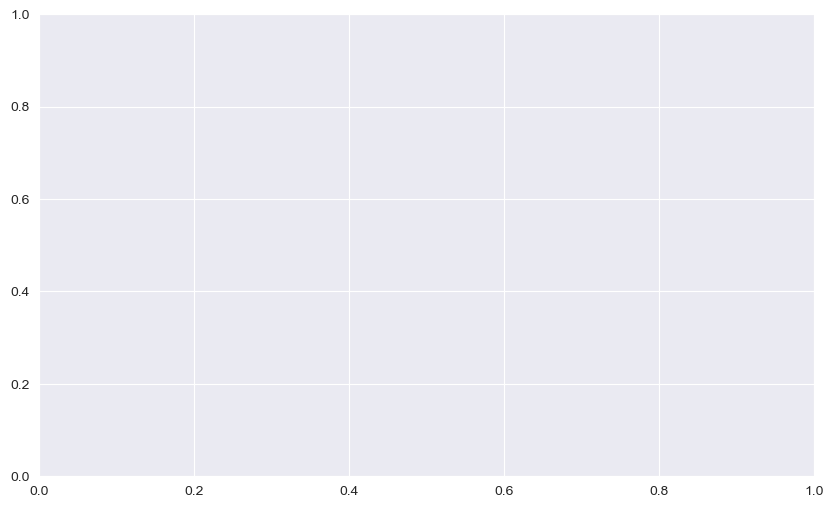

In [125]:
frequency_count_visualisation(job_df['Salary'])

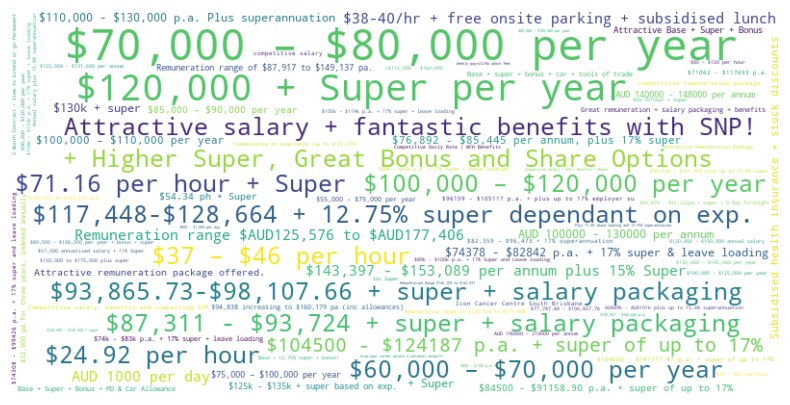

In [332]:
generate_wordcloud(Salary_counts_df, company_column='Salary', frequency_column='Frequency')

### Job Title

In [338]:
#Job Title variable
job_df['Job Title'].unique()

array(['Data Analyst', 'Data Lead', 'Senior Data Scientist',
       'Data Engineer', 'Data and Analytics Lead',
       'Principal HR Data Analyst',
       'Data Engineer - Investment Resilience & Planning',
       'Data and Insights Analyst',
       'Analytics and Decision Solutions Regional Lead',
       'Safety Data & Insights Lead',
       'Entry Data Analyst - Principal Analyst ( Multiple positions) APS4/APS5/APS6/EL1',
       'Manager - Data and Analytics',
       'Data & Business Insights Coordinator / Anaylst',
       'Machine Learning Engineer',
       'FDM Group - Cloud & Data Engineering Graduate Program', nan,
       'Teacher Aide - Mathematics/Science', 'Data Technology Champion',
       'Manager Data Analytics & Reporting', 'Statistician (Health Data)',
       'Senior Data Engineer - 3 month contract initially',
       'Performance Solutions Manager - Data and Systems',
       'Senior Data Modeller', 'Graduate SQL Consultant',
       'Principal Analyst', 'Senior Data Analy

In [372]:
#Frequncy count
Job_title_counts = job_df['Job Title'].value_counts()
Job_title_counts_df = Job_title_counts.reset_index()
Job_title_counts_df.columns = ['Job Title', 'Frequency']
display(Job_title_counts_df[0:11])
display(Job_title_counts_df[11:16])

Job Title  Frequency
0                                     Data Analyst         10
1                                    Data Engineer          5
2                            Laboratory Technician          5
3                             Senior Data Engineer          3
4             Lead Developer - Brisbane, Australia          3
5                               Accounts Assistant          2
6                                Software Engineer          2
7            Farm Systems Agronomist – Soil Carbon          2
8   Safe and Connected Futures Senior Practitioner          2
9                   Behaviour Support Practitioner          2
10                     Physics and Science Teacher          2

Job Title  Frequency
11        Manager Sustainability          2
12  Central Laboratory Assistant          2
13          Warehouse Supervisor          2
14        Research Fellow - ISSR          2
15        Sample Receipt Officer          2

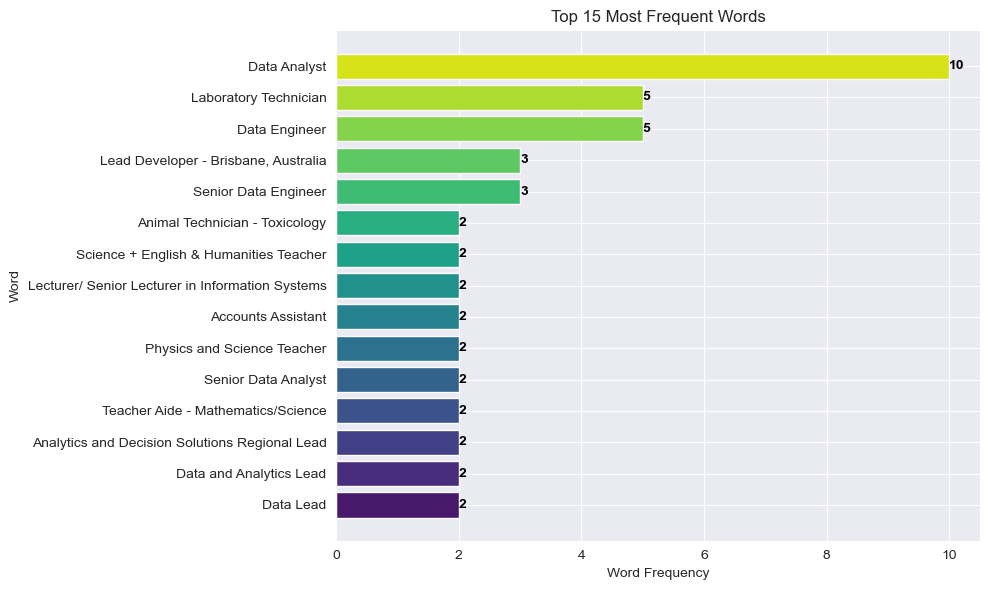

In [340]:
frequency_count_visualisation(job_df['Job Title'])

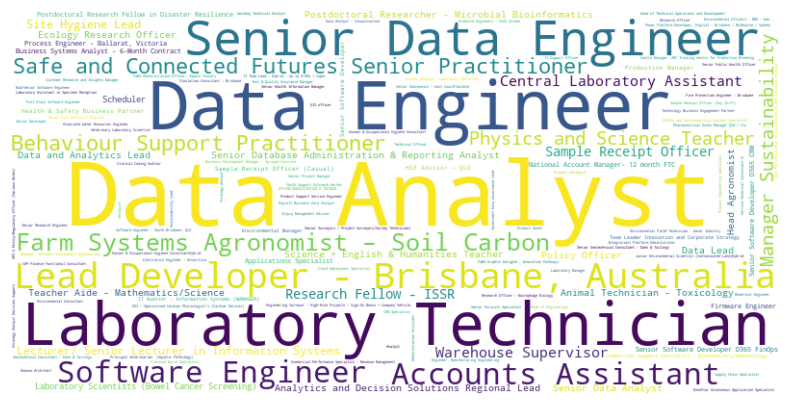

In [341]:
generate_wordcloud(Job_title_counts_df, company_column='Job Title', frequency_column='Frequency')

# Text Summarization task
#### Create Corpus

In [258]:
job_df = pd.read_csv(r"job_df.csv")

In [259]:
print(job_df.columns)

Index(['index', 'URL', 'Company', 'Location', 'Department', 'Position Type',
       'Salary', 'Description', 'Job Title'],
      dtype='object')


In [260]:
job_df['Corpus_raw'] = (
    job_df['Job Title'].fillna('') +
    ' ' +
    job_df['Company'].fillna('') +
    ' ' +
    job_df['Location'].fillna('') +
    ' ' +
    job_df['Department'].fillna('') +
    ' ' +
    job_df['Position Type'].fillna('') +
    ' ' +
    job_df['Description'].fillna('')
)

display(job_df) 

index                                                URL  \
0        0  https://www.seek.com.au/job/71826676?type=prom...   
1        1  https://www.seek.com.au/job/71667227?type=prom...   
2        2  https://www.seek.com.au/job/71795985?type=stan...   
3        3  https://www.seek.com.au/job/71662757?type=stan...   
4        4  https://www.seek.com.au/job/71836109?type=stan...   
..     ...                                                ...   
341    341  https://www.seek.com.au/job/71507589?type=stan...   
342    342  https://www.seek.com.au/job/71610316?type=stan...   
343    343  https://www.seek.com.au/job/71546073?type=stan...   
344    344  https://www.seek.com.au/job/71868849?type=stan...   
345    345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  \
0    Culture and Benefits:At Nexus, caring for our ...   
1    We are seeking a dedicated and detail-oriented...   
2    About UsWe’re an innovative and dynamic techno...   
3    Competitive salary package and employee benefi...   
4    A new role has become available for a mid to s...   
..                                                 ...   
341  We are currently tendering for works in Brisba...   
342  What if you could shape built and natural envi...   
343  Join our team of intelligent and collaborative...   
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Lo

In [261]:
display(job_df['Corpus_raw'][5])

"Data Analyst Centacare Brisbane QLD Business/Systems Analysts (Information & Communication Technology) Full time The Organisation: \xa0\xa0 Centacare, an Agency of the Catholic Archdiocese of Brisbane, is a values-based organisation dedicated to providing services to the entire community, irrespective of religion, circumstance, ethnicity, economic situation, age, gender, or ability. With a workforce of over 3,000 employees and volunteers, Centacare operates in more than 200 locations, supporting tens of thousands of people each year across various Directorates. \xa0\xa0 The role: \xa0\xa0 We currently have an exciting career progression opportunity for the role of Data Analyst. This role will be a permanent full time position. The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insights for decision-making, ensuring data quality, collaborating with various teams to optimise data usage, and con

In [262]:
def freq_words(x, terms=20):
    # Tokenize the words and filter out punctuation
    all_words = [word.lower() for word in word_tokenize(' '.join([text for text in x])) if word.isalnum()]

    # Create a frequency distribution
    fdist = nltk.FreqDist(all_words)

    # Create a DataFrame from the frequency distribution
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'Frequency': list(fdist.values())})

    # Select the top 'terms' most frequent words
    top_words = words_df.nlargest(columns="Frequency", n=terms)

    return top_words

top_words = freq_words(job_df['Corpus_raw'], 30)
print(top_words)

           word  Frequency
15          and      12645
35           to       6794
25          the       6288
27           of       4951
46            a       3988
90           in       3696
56         with       2753
19          for       2533
20          our       1982
49          you       1769
29           we       1657
0          data       1556
24           is       1395
126        will       1353
164          be       1233
45          are       1193
101          as       1168
183          or       1135
173        work       1057
51           on       1047
180  experience       1035
33         team        945
59         your        899
109        this        887
110          an        868
85         that        860
122        role        747
17           at        737
3       support        714
171      skills        667


#### View corpus word distibution with stop words

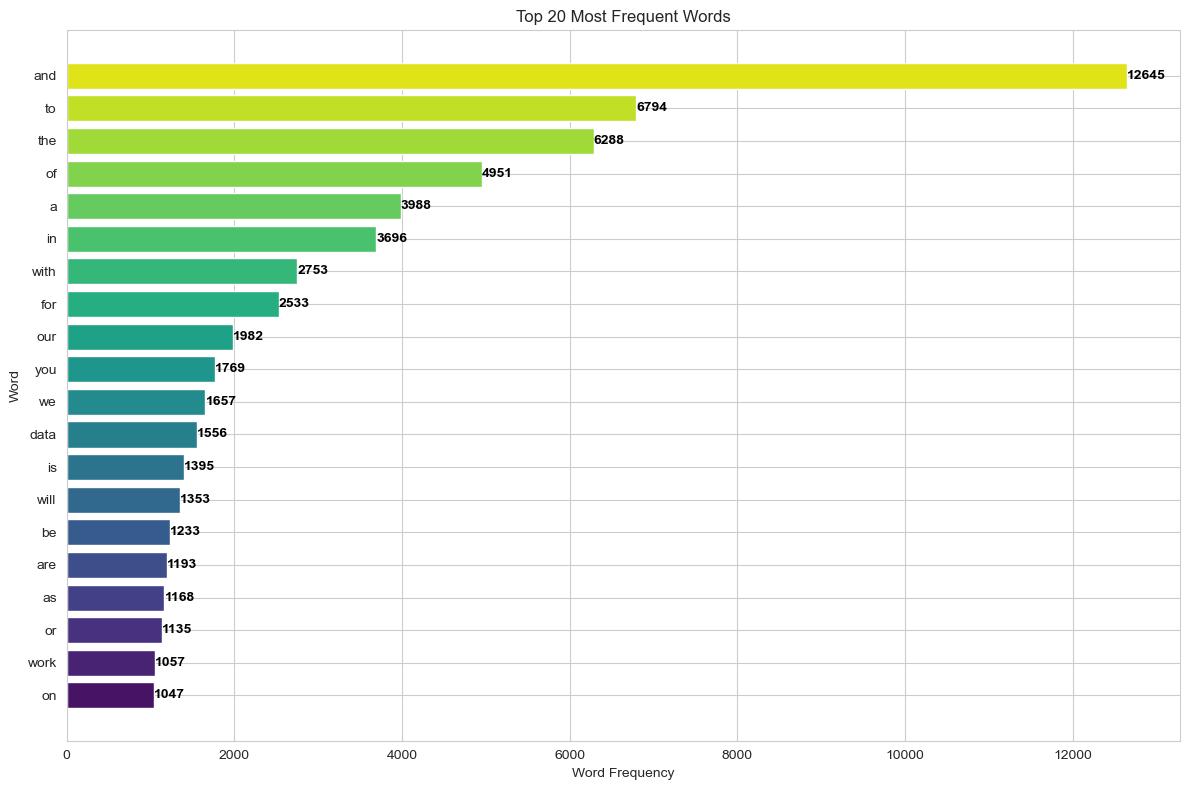

In [366]:
def plot_top_words_frequency(data_series, top_n=20, color_palette='viridis', figsize=(12, 8)):
    # Combine all text into a single string
    all_text = ' '.join(data_series)

    # Tokenize the text into words
    words = word_tokenize(all_text)

    # Remove punctuation
    words = [word.lower() for word in words if word.isalpha()]

    # Count word frequencies
    word_counts = Counter(words)

    # Get the top N most frequent words
    top_words = word_counts.most_common(top_n)[::-1]

    # Convert the data to a DataFrame for easier plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

    # Set a color palette for the bar chart
    colors = sns.color_palette(color_palette, len(top_words_df))

    # Plot the horizontal bar chart
    plt.figure(figsize=figsize)
    bars = plt.barh(top_words_df['Word'], top_words_df['Frequency'], color=colors)
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Word Frequency')
    plt.ylabel('Word')

    # Add data labels on the right of the bars
    for bar, label in zip(bars, top_words_df['Frequency']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label,
                 ha='left', va='center', color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_top_words_frequency(job_df['Corpus_raw'])

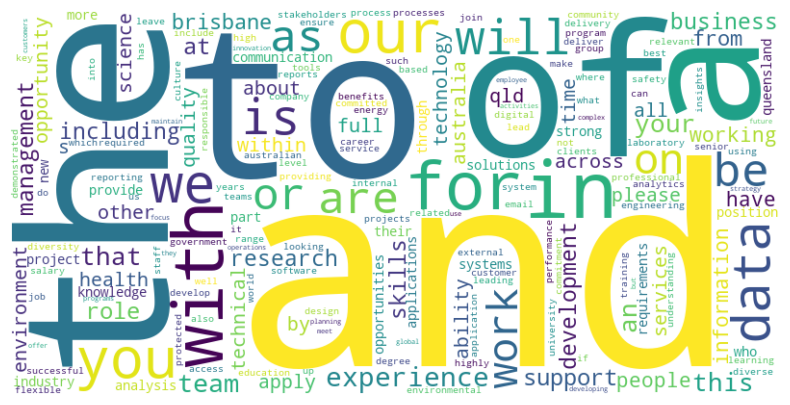

In [367]:
def create_wordcloud(x, terms=20):
    # Tokenize the words and filter out punctuation
    all_words = [word.lower() for word in word_tokenize(' '.join([text for text in x])) if word.isalnum()]

    # Create a frequency distribution
    fdist = nltk.FreqDist(all_words)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)

    # Display the WordCloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Call the function with your data
create_wordcloud(job_df['Corpus_raw'])

In [351]:
def text_preprocessing(uncleaned_text_corpus):
    lemmatizer = WordNetLemmatizer()
    corpus = []

    for i in range(0, len(uncleaned_text_corpus)):
        # Remove special characters, including '\xa0'
        text = re.sub('[^a-zA-Z0-9.,()]', ' ', uncleaned_text_corpus[i])
        
        # Tokenize the text
        words = word_tokenize(text)
        
        # Lemmatize each word
        words = [lemmatizer.lemmatize(word) for word in words]
        
        # Join the lemmatized words back into a sentence
        text = ' '.join(words)
        corpus.append(text)

    return corpus

In [352]:
job_df['Corpus'] = text_preprocessing(job_df['Corpus_raw'])
display(job_df) #353 rows x 11 columns
display(job_df.columns())

index                                                URL  \
0        0  https://www.seek.com.au/job/71826676?type=prom...   
1        1  https://www.seek.com.au/job/71667227?type=prom...   
2        2  https://www.seek.com.au/job/71795985?type=stan...   
3        3  https://www.seek.com.au/job/71662757?type=stan...   
4        4  https://www.seek.com.au/job/71836109?type=stan...   
..     ...                                                ...   
341    341  https://www.seek.com.au/job/71507589?type=stan...   
342    342  https://www.seek.com.au/job/71610316?type=stan...   
343    343  https://www.seek.com.au/job/71546073?type=stan...   
344    344  https://www.seek.com.au/job/71868849?type=stan...   
345    345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  \
0    Culture and Benefits:At Nexus, caring for our ...   
1    We are seeking a dedicated and detail-oriented...   
2    About UsWe’re an innovative and dynamic techno...   
3    Competitive salary package and employee benefi...   
4    A new role has become available for a mid to s...   
..                                                 ...   
341  We are currently tendering for works in Brisba...   
342  What if you could shape built and natural envi...   
343  Join our team of intelligent and collaborative...   
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Lo

In [353]:
display(job_df['Corpus_raw'][5])
display(job_df['Corpus'][5])

"Data Analyst Centacare Brisbane QLD Business/Systems Analysts (Information & Communication Technology) Full time The Organisation: \xa0\xa0 Centacare, an Agency of the Catholic Archdiocese of Brisbane, is a values-based organisation dedicated to providing services to the entire community, irrespective of religion, circumstance, ethnicity, economic situation, age, gender, or ability. With a workforce of over 3,000 employees and volunteers, Centacare operates in more than 200 locations, supporting tens of thousands of people each year across various Directorates. \xa0\xa0 The role: \xa0\xa0 We currently have an exciting career progression opportunity for the role of Data Analyst. This role will be a permanent full time position. The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insights for decision-making, ensuring data quality, collaborating with various teams to optimise data usage, and con

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . With a workforce of over 3,000 employee and volunteer , Centacare operates in more than 200 location , supporting ten of thousand of people each year across various Directorates . The role We currently have an exciting career progression opportunity for the role of Data Analyst . This role will be a permanent full time position . The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insight for decision making , ensuring data quality , collaborating with various team to optimise data usage , and contributing to operati

#### View corpus word distibution without stop words

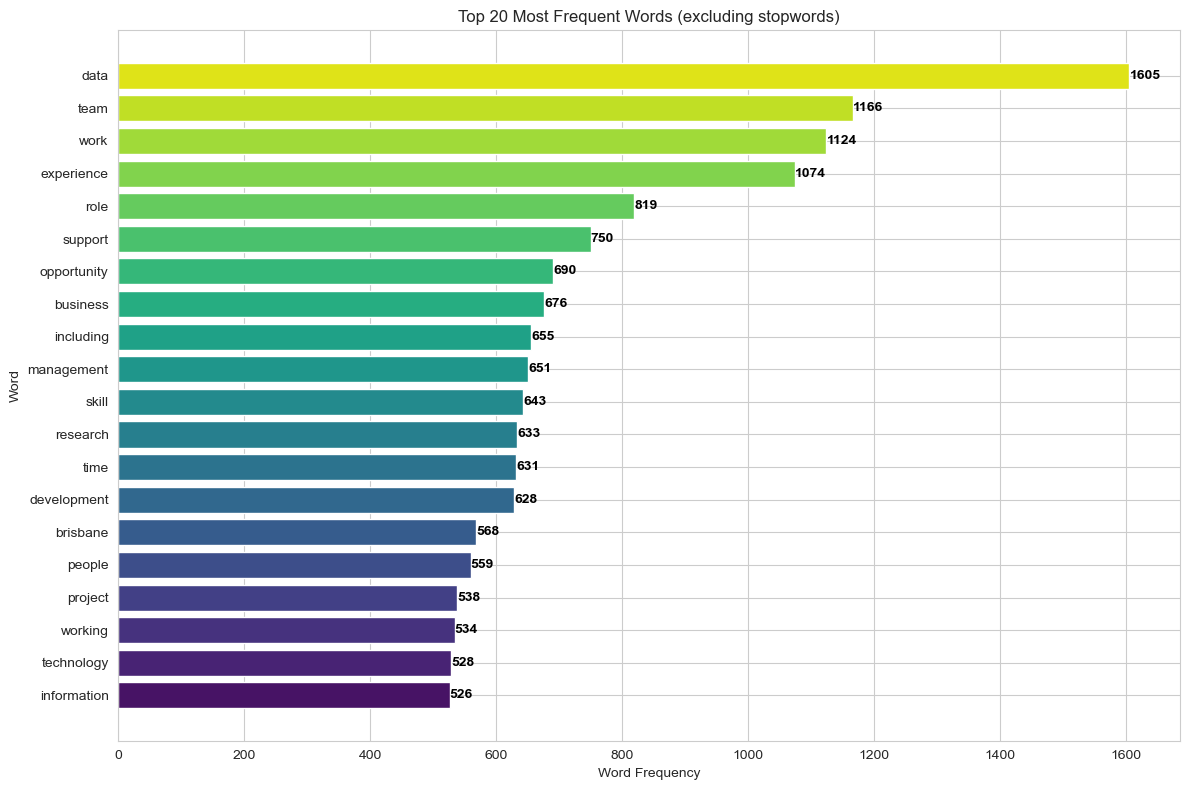

In [368]:
def plot_top_words_frequency(data_series, top_n=20, color_palette='viridis', figsize=(12, 8)):
    stop_words = set(stopwords.words('english'))
    
    # Combine all text into a single string
    all_text = ' '.join(data_series)

    # Tokenize the text into words
    words = word_tokenize(all_text)

    # Remove punctuation and stopwords
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Count word frequencies
    word_counts = Counter(words)

    # Get the top N most frequent words
    top_words = word_counts.most_common(top_n)[::-1]

    # Convert the data to a DataFrame for easier plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

    # Set a color palette for the bar chart
    colors = sns.color_palette(color_palette, len(top_words_df))

    # Plot the horizontal bar chart
    plt.figure(figsize=figsize)
    bars = plt.barh(top_words_df['Word'], top_words_df['Frequency'], color=colors)
    plt.title(f'Top {top_n} Most Frequent Words (excluding stopwords)')
    plt.xlabel('Word Frequency')
    plt.ylabel('Word')

    # Add data labels on the right of the bars
    for bar, label in zip(bars, top_words_df['Frequency']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, label,
                 ha='left', va='center', color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_top_words_frequency(job_df['Corpus'])

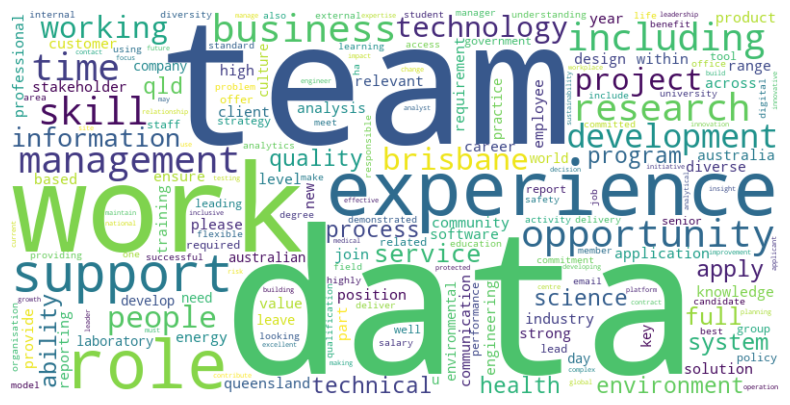

In [369]:
def create_wordcloud(x, terms=20):
    stop_words = set(stopwords.words('english'))
    
    # Tokenize the words and filter out stopwords and punctuation
    all_words = [word.lower() for word in word_tokenize(' '.join([text for text in x])) if word.isalnum() and word.lower() not in stop_words]

    # Create a frequency distribution
    fdist = nltk.FreqDist(all_words)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)

    # Display the WordCloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Call the function with your data
create_wordcloud(job_df['Corpus'])

In [356]:
#Just to check to see what words are in all docuemnts and which only occur in one document
document_word_sets = []

# Create a list of sets where each set contains unique words for each document
for document in job_df['Corpus']:
    words = set(document.split())
    document_word_sets.append(words)

# Print unique words for each document
for i, words in enumerate(document_word_sets):
    print(f"Document {i + 1} unique words: {words}")

# Find words that appear in all documents
words_in_all_docs = set(document_word_sets[0])
for word_set in document_word_sets[1:]:
    words_in_all_docs.intersection_update(word_set)

# Find words that appear in only one document
words_in_one_doc = set()
for word_set in document_word_sets:
    if len(word_set) == 1:
        words_in_one_doc.update(word_set)

# Print the results
print("\nWords in all documents:")
print(words_in_all_docs)

print("\nWords in only one document:")
print(words_in_one_doc)

Document 1 unique words: {'integrity', 'QLD', 'About', 'amongst', 'approach', 'Knowledge', 'purpose', 'engagement', 'Office', 'context', 'inclusion', 'and', 'trust', 'thrive', 'Contract', 'group', 'Nexus', 'our', 'time', 'existing', 'patient', 'Develop', 'mapping', 'Dayforce', 'accuracy', 'provider', 'at', 'Generate', 'strong', 'in', 'background', 'centre', 'largest', ')', 'task', 'Database', '(', 'hospital', 'day', 'organisational', 'advantage', 'Proficiency', 'structure', 'Reporting', 'Hospitals', '1600', 'progress', 'prioritise', 'outlining', 'employee', '28', 'feel', 'Australian', 'by', 'successful', 'positive', 'ability', 'Data', 'talented', 'operates', 'preferably', 'include', 'Manager', 'to', 'visualisation', 'including', 'Toowong', 'providing', 'effort', 'HCM', 'people', 'want', 'non', 'opportunity', 'for', 'Passport', 'Role', 'one', 'letter', 'urban', 'Fitness', 'monitor', 'Engagement', 'tool', 'portfolio', 'To', 'employer', 'great', '.', 'equal', 'short', 'implementation', ',

In [357]:
#Save progress as csv
job_df.to_csv('job_df_corpus.csv', index = False)

In [102]:
#Load csv if necessary
job_summary_df = pd.read_csv(r'job_df_corpus.csv')

# Extract summarization
#### Job Summarization: TextRank

In [375]:
def summarize_job_description_TextRank(job_description, num_sentences=5):
    # Tokenize and parse the job description
    words = word_tokenize(job_description)
    sentences = ' '.join(words)

    parser = PlaintextParser.from_string(sentences, Tokenizer("english"))

    # Use TextRank for summarization
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)

    # Combine sentences to form the summary text
    summary_text = " ".join(str(sentence) for sentence in summary)

    return summary_text

job_summary_df['Job_Summaries_TextRank'] = job_summary_df['Corpus'].apply(summarize_job_description_TextRank)

print(job_summary_df['Job_Summaries_TextRank'][5])

Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insight for decision making , ensuring data quality , collaborating with various team to optimise data usage , and contributing to operational improvement . Strong data analysis skill , with experience in using data analytics tool and technique ( with certification in data analytics and visualisation tool like SQL , Boomi , Power BI desirable ) Excellent interpersonal skill , including problem resolution , negotiation , the ability to guide system user and communicat

In [359]:
#Compare corpus to job summary to evaluate and change parameters if needed
display(job_summary_df['Corpus'][5])
display(job_summary_df['Job_Summaries_TextRank'][5])

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . With a workforce of over , employee and volunteer , Centacare operates in more than location , supporting ten of thousand of people each year across various Directorates . The role We currently have an exciting career progression opportunity for the role of Data Analyst . This role will be a permanent full time position . The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insight for decision making , ensuring data quality , collaborating with various team to optimise data usage , and contributing to operational imp

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insight for decision making , ensuring data quality , collaborating with various team to optimise data usage , and contributing to operational improvement . Strong data analysis skill , with experience in using data analytics tool and technique ( with certification in data analytics and visualisation tool like SQL , Boomi , Power BI desirable ) Excellent interpersonal skill , including problem resolution , negotiation , the ability to guide system user and communica

#### Job Summarization: LSA

In [360]:
def summarize_job_description_lsa(job_description):
    # Tokenize and parse the job description
    words = word_tokenize(job_description)
    sentences = ' '.join(words)

    parser = PlaintextParser.from_string(sentences, Tokenizer("english"))

    # Use LSA (Latent Semantic Analysis) for summarization
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, 8)  # Adjust the number of sentences

    # Combine sentences to form the summary text
    summary_text = " ".join(str(sentence) for sentence in summary)

    return summary_text

# Add the summaries to the DataFrame
job_summary_df['Job_Summaries_lsa'] = job_summary_df['Corpus'].apply(summarize_job_description_lsa)

In [361]:
#Compare corpus to job summary to evaluate and change parameters if needed
display(job_summary_df['Job_Summaries_TextRank'][5])
display(job_summary_df['Job_Summaries_lsa'][5])

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insight for decision making , ensuring data quality , collaborating with various team to optimise data usage , and contributing to operational improvement . Strong data analysis skill , with experience in using data analytics tool and technique ( with certification in data analytics and visualisation tool like SQL , Boomi , Power BI desirable ) Excellent interpersonal skill , including problem resolution , negotiation , the ability to guide system user and communica

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . Key Duties Collaborate with key stakeholder to ensure accurate documentation , planning , and efficient use of data while fostering continuous improvement and compliance with data governance policy . Generate report to support business goal , maintain data quality , collaborate across team , analyse performance , communicate finding effectively , follow data governance , and stay updated on industry trend for data analysis and reporting in the aged care and disability sector . Strong data analysis skill , with experience in using data analytics tool and technique ( with certification in data analytics and vi

#### Job Summarization: BART

In [363]:
# Load the BART-based summarization model
bart_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [364]:
# Create an empty list to store the summaries
summaries = []

# Set chunk size to the maximum sequence length
chunk_size = 1024

# Iterate through each document in the corpus
for idx, job_description in enumerate(job_summary_df['Corpus']):
    # Split the job description into chunks
    chunks = [job_description[i:i + chunk_size] for i in range(0, len(job_description), chunk_size)]

    # Generate a summary for each chunk
    chunk_summaries = []
    for chunk in chunks:
        summary = bart_summarizer(chunk, max_length=120, min_length=50, length_penalty=1.0, num_beams=6)
        chunk_summaries.append(summary[0]['summary_text'])

    # Concatenate the chunk summaries to form the final summary
    final_summary = ' '.join(chunk_summaries)

    # Print progress
    print(f"Summarization {idx + 1} completed")

    # Append the final summary to the list
    summaries.append(final_summary)

# Add the summaries to the DataFrame
job_summary_df['Job_Summaries_Bart'] = summaries

Summarization 1 completed


Your max_length is set to 120, but your input_length is only 12. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Summarization 2 completed


Your max_length is set to 120, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarization 3 completed
Summarization 4 completed


Your max_length is set to 120, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarization 5 completed


Your max_length is set to 120, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarization 6 completed


Your max_length is set to 120, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarization 7 completed


Your max_length is set to 120, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 8 completed


Your max_length is set to 120, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Summarization 9 completed


Your max_length is set to 120, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Summarization 10 completed
Summarization 11 completed


Your max_length is set to 120, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarization 12 completed


Your max_length is set to 120, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 13 completed


Your max_length is set to 120, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarization 14 completed
Summarization 15 completed


Your max_length is set to 120, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Summarization 16 completed


Your max_length is set to 120, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Summarization 17 completed
Summarization 18 completed
Summarization 19 completed
Summarization 20 completed


Your max_length is set to 120, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 21 completed


Your max_length is set to 120, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 22 completed


Your max_length is set to 120, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarization 23 completed


Your max_length is set to 120, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarization 24 completed


Your max_length is set to 120, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarization 25 completed


Your max_length is set to 120, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Summarization 26 completed


Your max_length is set to 120, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarization 27 completed


Your max_length is set to 120, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarization 28 completed
Summarization 29 completed
Summarization 30 completed


Your max_length is set to 120, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarization 31 completed


Your max_length is set to 120, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Summarization 32 completed
Summarization 33 completed


Your max_length is set to 120, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summarization 34 completed


Your max_length is set to 120, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summarization 35 completed
Summarization 36 completed
Summarization 37 completed
Summarization 38 completed
Summarization 39 completed


Your max_length is set to 120, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summarization 40 completed


Your max_length is set to 120, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarization 41 completed


Your max_length is set to 120, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Summarization 42 completed
Summarization 43 completed


Your max_length is set to 120, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summarization 44 completed


Your max_length is set to 120, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Summarization 45 completed


Your max_length is set to 120, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarization 46 completed
Summarization 47 completed


Your max_length is set to 120, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarization 48 completed
Summarization 49 completed


Your max_length is set to 120, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Summarization 50 completed


Your max_length is set to 120, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Summarization 51 completed


Your max_length is set to 120, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 52 completed
Summarization 53 completed
Summarization 54 completed
Summarization 55 completed
Summarization 56 completed
Summarization 57 completed


Your max_length is set to 120, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Summarization 58 completed


Your max_length is set to 120, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Summarization 59 completed


Your max_length is set to 120, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summarization 60 completed
Summarization 61 completed
Summarization 62 completed
Summarization 63 completed


Your max_length is set to 120, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


Summarization 64 completed


Your max_length is set to 120, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarization 65 completed


Your max_length is set to 120, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Summarization 66 completed


Your max_length is set to 120, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarization 67 completed


Your max_length is set to 120, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summarization 68 completed


Your max_length is set to 120, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Summarization 69 completed


Your max_length is set to 120, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summarization 70 completed


Your max_length is set to 120, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarization 71 completed
Summarization 72 completed
Summarization 73 completed


Your max_length is set to 120, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Summarization 74 completed


Your max_length is set to 120, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Summarization 75 completed


Your max_length is set to 120, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Summarization 76 completed
Summarization 77 completed


Your max_length is set to 120, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summarization 78 completed
Summarization 79 completed


Your max_length is set to 120, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summarization 80 completed


Your max_length is set to 120, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summarization 81 completed


Your max_length is set to 120, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Summarization 82 completed


Your max_length is set to 120, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 83 completed
Summarization 84 completed


Your max_length is set to 120, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summarization 85 completed


Your max_length is set to 120, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summarization 86 completed
Summarization 87 completed


Your max_length is set to 120, but your input_length is only 3. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)


Summarization 88 completed
Summarization 89 completed
Summarization 90 completed


Your max_length is set to 120, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarization 91 completed
Summarization 92 completed


Your max_length is set to 120, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Summarization 93 completed
Summarization 94 completed


Your max_length is set to 120, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 95 completed


Your max_length is set to 120, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summarization 96 completed
Summarization 97 completed


Your max_length is set to 120, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summarization 98 completed


Your max_length is set to 120, but your input_length is only 23. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Summarization 99 completed
Summarization 100 completed
Summarization 101 completed
Summarization 102 completed


Your max_length is set to 120, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Summarization 103 completed


Your max_length is set to 120, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summarization 104 completed
Summarization 105 completed


Your max_length is set to 120, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Summarization 106 completed
Summarization 107 completed
Summarization 108 completed


Your max_length is set to 120, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Summarization 109 completed


Your max_length is set to 120, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summarization 110 completed
Summarization 111 completed


Your max_length is set to 120, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Summarization 112 completed
Summarization 113 completed


Your max_length is set to 120, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarization 114 completed


Your max_length is set to 120, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 115 completed
Summarization 116 completed


Your max_length is set to 120, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 117 completed
Summarization 118 completed
Summarization 119 completed


Your max_length is set to 120, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Summarization 120 completed


Your max_length is set to 120, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 121 completed


Your max_length is set to 120, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Summarization 122 completed


Your max_length is set to 120, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarization 123 completed


Your max_length is set to 120, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 124 completed
Summarization 125 completed


Your max_length is set to 120, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


Summarization 126 completed


Your max_length is set to 120, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summarization 127 completed


Your max_length is set to 120, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarization 128 completed


Your max_length is set to 120, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Summarization 129 completed


Your max_length is set to 120, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Summarization 130 completed


Your max_length is set to 120, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarization 131 completed


Your max_length is set to 120, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 132 completed


Your max_length is set to 120, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarization 133 completed
Summarization 134 completed


Your max_length is set to 120, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summarization 135 completed
Summarization 136 completed


Your max_length is set to 120, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarization 137 completed


Your max_length is set to 120, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summarization 138 completed


Your max_length is set to 120, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Summarization 139 completed


Your max_length is set to 120, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarization 140 completed


Your max_length is set to 120, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 141 completed
Summarization 142 completed
Summarization 143 completed
Summarization 144 completed


Your max_length is set to 120, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarization 145 completed


Your max_length is set to 120, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarization 146 completed
Summarization 147 completed


Your max_length is set to 120, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarization 148 completed


Your max_length is set to 120, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarization 149 completed
Summarization 150 completed


Your max_length is set to 120, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 151 completed
Summarization 152 completed


Your max_length is set to 120, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Summarization 153 completed


Your max_length is set to 120, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Summarization 154 completed
Summarization 155 completed
Summarization 156 completed


Your max_length is set to 120, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarization 157 completed
Summarization 158 completed


Your max_length is set to 120, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


Summarization 159 completed


Your max_length is set to 120, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Summarization 160 completed


Your max_length is set to 120, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 161 completed
Summarization 162 completed


Your max_length is set to 120, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarization 163 completed
Summarization 164 completed
Summarization 165 completed


Your max_length is set to 120, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarization 166 completed


Your max_length is set to 120, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Summarization 167 completed
Summarization 168 completed


Your max_length is set to 120, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Summarization 169 completed


Your max_length is set to 120, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Summarization 170 completed
Summarization 171 completed
Summarization 172 completed
Summarization 173 completed


Your max_length is set to 120, but your input_length is only 56. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 174 completed


Your max_length is set to 120, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarization 175 completed


Your max_length is set to 120, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


Summarization 176 completed


Your max_length is set to 120, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 177 completed


Your max_length is set to 120, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarization 178 completed
Summarization 179 completed


Your max_length is set to 120, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarization 180 completed


Your max_length is set to 120, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 181 completed
Summarization 182 completed


Your max_length is set to 120, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


Summarization 183 completed
Summarization 184 completed


Your max_length is set to 120, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summarization 185 completed
Summarization 186 completed


Your max_length is set to 120, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarization 187 completed


Your max_length is set to 120, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Summarization 188 completed


Your max_length is set to 120, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarization 189 completed


Your max_length is set to 120, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 190 completed


Your max_length is set to 120, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarization 191 completed
Summarization 192 completed


Your max_length is set to 120, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


Summarization 193 completed


Your max_length is set to 120, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


Summarization 194 completed


Your max_length is set to 120, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarization 195 completed


Your max_length is set to 120, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Summarization 196 completed


Your max_length is set to 120, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 197 completed


Your max_length is set to 120, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Summarization 198 completed


Your max_length is set to 120, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summarization 199 completed
Summarization 200 completed
Summarization 201 completed
Summarization 202 completed


Your max_length is set to 120, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarization 203 completed


Your max_length is set to 120, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Summarization 204 completed


Your max_length is set to 120, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Summarization 205 completed


Your max_length is set to 120, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


Summarization 206 completed


Your max_length is set to 120, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Summarization 207 completed
Summarization 208 completed
Summarization 209 completed


Your max_length is set to 120, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarization 210 completed


Your max_length is set to 120, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


Summarization 211 completed


Your max_length is set to 120, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Summarization 212 completed


Your max_length is set to 120, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Summarization 213 completed


Your max_length is set to 120, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarization 214 completed
Summarization 215 completed
Summarization 216 completed


Your max_length is set to 120, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


Summarization 217 completed


Your max_length is set to 120, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Summarization 218 completed


Your max_length is set to 120, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarization 219 completed


Your max_length is set to 120, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 220 completed
Summarization 221 completed
Summarization 222 completed


Your max_length is set to 120, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Summarization 223 completed


Your max_length is set to 120, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


Summarization 224 completed
Summarization 225 completed


Your max_length is set to 120, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarization 226 completed


Your max_length is set to 120, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Summarization 227 completed
Summarization 228 completed


Your max_length is set to 120, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 229 completed


Your max_length is set to 120, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


Summarization 230 completed


Your max_length is set to 120, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 231 completed


Your max_length is set to 120, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 232 completed
Summarization 233 completed


Your max_length is set to 120, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Summarization 234 completed
Summarization 235 completed
Summarization 236 completed


Your max_length is set to 120, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summarization 237 completed
Summarization 238 completed
Summarization 239 completed


Your max_length is set to 120, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


Summarization 240 completed
Summarization 241 completed
Summarization 242 completed
Summarization 243 completed
Summarization 244 completed


Your max_length is set to 120, but your input_length is only 19. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Summarization 245 completed
Summarization 246 completed


Your max_length is set to 120, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Summarization 247 completed


Your max_length is set to 120, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarization 248 completed
Summarization 249 completed


Your max_length is set to 120, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Summarization 250 completed


Your max_length is set to 120, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 251 completed


Your max_length is set to 120, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


Summarization 252 completed


Your max_length is set to 120, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Summarization 253 completed


Your max_length is set to 120, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


Summarization 254 completed


Your max_length is set to 120, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 255 completed


Your max_length is set to 120, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


Summarization 256 completed


Your max_length is set to 120, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarization 257 completed


Your max_length is set to 120, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


Summarization 258 completed


Your max_length is set to 120, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Summarization 259 completed


Your max_length is set to 120, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


Summarization 260 completed


Your max_length is set to 120, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summarization 261 completed
Summarization 262 completed


Your max_length is set to 120, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


Summarization 263 completed
Summarization 264 completed


Your max_length is set to 120, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


Summarization 265 completed
Summarization 266 completed


Your max_length is set to 120, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summarization 267 completed
Summarization 268 completed


Your max_length is set to 120, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


Summarization 269 completed
Summarization 270 completed
Summarization 271 completed
Summarization 272 completed
Summarization 273 completed


Your max_length is set to 120, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 274 completed


Your max_length is set to 120, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Summarization 275 completed
Summarization 276 completed


Your max_length is set to 120, but your input_length is only 15. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Summarization 277 completed
Summarization 278 completed
Summarization 279 completed
Summarization 280 completed


Your max_length is set to 120, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 281 completed


Your max_length is set to 120, but your input_length is only 61. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarization 282 completed
Summarization 283 completed


Your max_length is set to 120, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Summarization 284 completed


Your max_length is set to 120, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 285 completed
Summarization 286 completed
Summarization 287 completed


Your max_length is set to 120, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


Summarization 288 completed
Summarization 289 completed
Summarization 290 completed
Summarization 291 completed


Your max_length is set to 120, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


Summarization 292 completed


Your max_length is set to 120, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)


Summarization 293 completed


Your max_length is set to 120, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Summarization 294 completed


Your max_length is set to 120, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summarization 295 completed


Your max_length is set to 120, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


Summarization 296 completed
Summarization 297 completed
Summarization 298 completed
Summarization 299 completed


Your max_length is set to 120, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Summarization 300 completed
Summarization 301 completed
Summarization 302 completed


Your max_length is set to 120, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarization 303 completed


Your max_length is set to 120, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


Summarization 304 completed


Your max_length is set to 120, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Summarization 305 completed
Summarization 306 completed
Summarization 307 completed


Your max_length is set to 120, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 308 completed


Your max_length is set to 120, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Summarization 309 completed


Your max_length is set to 120, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Summarization 310 completed
Summarization 311 completed


Your max_length is set to 120, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summarization 312 completed
Summarization 313 completed


Your max_length is set to 120, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


Summarization 314 completed


Your max_length is set to 120, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Summarization 315 completed


Your max_length is set to 120, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarization 316 completed


Your max_length is set to 120, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Summarization 317 completed
Summarization 318 completed


Your max_length is set to 120, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summarization 319 completed


Your max_length is set to 120, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarization 320 completed
Summarization 321 completed
Summarization 322 completed


Your max_length is set to 120, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


Summarization 323 completed


Your max_length is set to 120, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarization 324 completed


Your max_length is set to 120, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


Summarization 325 completed
Summarization 326 completed
Summarization 327 completed
Summarization 328 completed
Summarization 329 completed


Your max_length is set to 120, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


Summarization 330 completed


Your max_length is set to 120, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Summarization 331 completed


Your max_length is set to 120, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


Summarization 332 completed


Your max_length is set to 120, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


Summarization 333 completed


Your max_length is set to 120, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Summarization 334 completed
Summarization 335 completed


Your max_length is set to 120, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Summarization 336 completed


Your max_length is set to 120, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Summarization 337 completed


Your max_length is set to 120, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


Summarization 338 completed


Your max_length is set to 120, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Summarization 339 completed
Summarization 340 completed


Your max_length is set to 120, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Summarization 341 completed


Your max_length is set to 120, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Summarization 342 completed
Summarization 343 completed
Summarization 344 completed
Summarization 345 completed
Summarization 346 completed


In [110]:
#Compare corpus to job summary to evaluate and change parameters if needed
display(job_summary_df['Job_Summaries_lsa'][5])
display(job_summary_df['Job_Summaries_Bart'][5])

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . Key Duties Collaborate with key stakeholder to ensure accurate documentation , planning , and efficient use of data while fostering continuous improvement and compliance with data governance policy . Generate report to support business goal , maintain data quality , collaborate across team , analyse performance , communicate finding effectively , follow data governance , and stay updated on industry trend for data analysis and reporting in the aged care and disability sector . Strong data analysis skill , with experience in using data analytics tool and technique ( with certification in data analytics and vi

'Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program. The Data Analyst will provide timely and accurate insight for decision making. This role will be a permanent full time position. The role is an exciting career progression opportunity for the Data Analyst. A minimum of year previous experience in data analysis or a related role within the Not For Profit space. Follow change management process including analysis, planning, development, documentation, implementation and testing. Generate report to support business goal, maintain data quality and collaborate across team. Strong data analysis skill, with experience in using data analytics tool and technique. Excellent interpersonal skill, including problem resolution and negotiation. Excellent time management skill with the ability to manage activity within established timeframes. Sound decision making, conflict resolution and problem solving skill. You will be able to be part of a

# Abstract summarization
#### Job Summarization: T5 (did not produce a good summary, will not use)

In [111]:
# Load pre-trained T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [112]:
def t5_summarizer(text, max_length=300, min_length=50):
    # Tokenize the input text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate the summary
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=1.0, num_beams=6, early_stopping=False)
    
    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

# Apply T5 summarization to each document
summaries = []

for idx, job_description in enumerate(job_summary_df['Corpus']):
    summary = t5_summarizer(job_description)
    print(f"Summarization {idx + 1} completed")
    summaries.append(summary)

# Add the summaries to the DataFrame
job_summary_df['Job_Summaries_T5'] = summaries

Summarization 1 completed
Summarization 2 completed
Summarization 3 completed
Summarization 4 completed
Summarization 5 completed
Summarization 6 completed
Summarization 7 completed
Summarization 8 completed
Summarization 9 completed
Summarization 10 completed
Summarization 11 completed
Summarization 12 completed
Summarization 13 completed
Summarization 14 completed
Summarization 15 completed
Summarization 16 completed
Summarization 17 completed
Summarization 18 completed
Summarization 19 completed
Summarization 20 completed
Summarization 21 completed
Summarization 22 completed
Summarization 23 completed
Summarization 24 completed
Summarization 25 completed
Summarization 26 completed
Summarization 27 completed
Summarization 28 completed
Summarization 29 completed
Summarization 30 completed
Summarization 31 completed
Summarization 32 completed
Summarization 33 completed
Summarization 34 completed
Summarization 35 completed
Summarization 36 completed
Summarization 37 completed
Summarizat

In [113]:
#Compare corpus to job summary to evaluate and change parameters if needed
display(job_summary_df['Job_Summaries_lsa'][5])
display(job_summary_df['Job_Summaries_Bart'][5])
display(job_summary_df['Job_Summaries_T5'][5])

'Data Analyst Centacare Brisbane QLD Business Systems Analysts ( Information Communication Technology ) Full time The Organisation Centacare , an Agency of the Catholic Archdiocese of Brisbane , is a value based organisation dedicated to providing service to the entire community , irrespective of religion , circumstance , ethnicity , economic situation , age , gender , or ability . Key Duties Collaborate with key stakeholder to ensure accurate documentation , planning , and efficient use of data while fostering continuous improvement and compliance with data governance policy . Generate report to support business goal , maintain data quality , collaborate across team , analyse performance , communicate finding effectively , follow data governance , and stay updated on industry trend for data analysis and reporting in the aged care and disability sector . Strong data analysis skill , with experience in using data analytics tool and technique ( with certification in data analytics and vi

'Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program. The Data Analyst will provide timely and accurate insight for decision making. This role will be a permanent full time position. The role is an exciting career progression opportunity for the Data Analyst. A minimum of year previous experience in data analysis or a related role within the Not For Profit space. Follow change management process including analysis, planning, development, documentation, implementation and testing. Generate report to support business goal, maintain data quality and collaborate across team. Strong data analysis skill, with experience in using data analytics tool and technique. Excellent interpersonal skill, including problem resolution and negotiation. Excellent time management skill with the ability to manage activity within established timeframes. Sound decision making, conflict resolution and problem solving skill. You will be able to be part of a

'the organisation is a value based organisation dedicated to providing service to the entire community. irrespective of religion, circumstance, ethnicity, economic situation, age, gender, or ability. the organisation is fully committed to child safety and ha a zero tolerance to abuse of child or vulnerable adult.'

In [118]:
#Save progress as csv
job_summary_df.to_csv('job_summary_df.csv', index = False)

In [26]:
#Load csv if necessary
job_summary_df = pd.read_csv(r'job_summary_df.csv')

# Evaluation using ROUGE

In [387]:
#Create list of methods used
methods = ['TextRank', 'lsa', 'Bart']
references = job_summary_df['Corpus']

# Iterate over each summarization method
for method in methods:
    hypotheses = job_summary_df[f'Job_Summaries_{method}']

    # Set up the data for Rouge
    for idx, (hypothesis, reference) in enumerate(zip(hypotheses, references)):
        # Run Rouge for unigrams (ROUGE-1)
        scores_unigram = rouge_score.rouge_n(hypothesis, reference, 1)

        # Run Rouge for bigrams (ROUGE-2)
        scores_bigram = rouge_score.rouge_n(hypothesis, reference, 2)

        # Run Rouge for trigrams (ROUGE-3)
        scores_trigram = rouge_score.rouge_n(hypothesis, reference, 3)

        # Calculate average scores for precision, recall, and F1 across all n-gram types
        avg_precision = (scores_unigram['p'] + scores_bigram['p'] + scores_trigram['p']) / 3
        avg_recall = (scores_unigram['r'] + scores_bigram['r'] + scores_trigram['r']) / 3
        avg_f1 = (scores_unigram['f'] + scores_bigram['f'] + scores_trigram['f']) / 3

        # Print the results for each document and method
        print(f"\nROUGE Scores for Document {idx + 1} - {method} (Average):")
        pprint({
            'precision': avg_precision,
            'recall': avg_recall,
            'f': avg_f1
        })

        # Add average scores to job_summary_df
        job_summary_df.at[idx, f'{method}_Avg_Precision'] = avg_precision
        job_summary_df.at[idx, f'{method}_Avg_Recall'] = avg_recall
        job_summary_df.at[idx, f'{method}_Avg_F1'] = avg_f1

print("\nUpdated DataFrame with ROUGE Scores:")
print(job_summary_df)


ROUGE Scores for Document 1 - TextRank (Average):
{'f': 0.9645847998327644, 'precision': 1.0, 'recall': 0.9326006791285604}

ROUGE Scores for Document 2 - TextRank (Average):
{'f': 0.9571946598989376, 'precision': 1.0, 'recall': 0.9182310116238189}

ROUGE Scores for Document 3 - TextRank (Average):
{'f': 0.8646578110682847, 'precision': 1.0, 'recall': 0.7699757504735439}

ROUGE Scores for Document 4 - TextRank (Average):
{'f': 0.9249626866678158, 'precision': 1.0, 'recall': 0.8637357454478076}

ROUGE Scores for Document 5 - TextRank (Average):
{'f': 0.999999995, 'precision': 1.0, 'recall': 1.0}

ROUGE Scores for Document 6 - TextRank (Average):
{'f': 0.8392473114656628, 'precision': 1.0, 'recall': 0.7310227141704139}

ROUGE Scores for Document 7 - TextRank (Average):
{'f': 0.9849339691036686, 'precision': 1.0, 'recall': 0.9705959183673469}

ROUGE Scores for Document 8 - TextRank (Average):
{'f': 0.8905535443122042, 'precision': 1.0, 'recall': 0.8098961400659349}

ROUGE Scores for Docu

In [29]:
#Save progress as csv
job_summary_df.to_csv('job_summary_df_final.csv', index=False)

In [388]:
#Take the average score for each evaluation metric for TextRank summarization method
tr_p_average_value = job_summary_df['TextRank_Avg_Precision'].mean()
tr_r_average_value = job_summary_df['TextRank_Avg_Recall'].mean()
tr_f1_average_value = job_summary_df['TextRank_Avg_F1'].mean()

# Round the average values to two decimal places
tr_p_average_rounded = round(tr_p_average_value, 2)
tr_r_average_rounded = round(tr_r_average_value, 2)
tr_f1_average_rounded = round(tr_f1_average_value, 2)

print(f"Average evaluation scores of TextRank are: Precision - {tr_p_average_rounded}, Recall - {tr_r_average_rounded}, and F1 - {tr_f1_average_rounded}.")

#Take the average score for each evaluation metric for LSA summarization method
lsa_p_average_value = job_summary_df['lsa_Avg_Precision'].mean()
lsa_r_average_value = job_summary_df['lsa_Avg_Recall'].mean()
lsa_f1_average_value = job_summary_df['lsa_Avg_F1'].mean()

# Round the average values to two decimal places
lsa_p_average_rounded = round(lsa_p_average_value, 2)
lsa_r_average_rounded = round(lsa_r_average_value, 2)
lsa_f1_average_rounded = round(lsa_f1_average_value, 2)

print(f"Average evaluation scores of LSA are: Precision - {lsa_p_average_rounded}, Recall - {lsa_r_average_rounded}, and F1 - {lsa_f1_average_rounded}.")

#Take the average score for each evaluation metric for Bart summarization method
bart_p_average_value = job_summary_df['Bart_Avg_Precision'].mean()
bart_r_average_value = job_summary_df['Bart_Avg_Recall'].mean()
bart_f1_average_value = job_summary_df['Bart_Avg_F1'].mean()

# Round the average values to two decimal places
bart_p_average_rounded = round(bart_p_average_value, 2)
bart_r_average_rounded = round(bart_r_average_value, 2)
bart_f1_average_rounded = round(bart_f1_average_value, 2)

print(f"Average evaluation scores of Bart are: Precision - {bart_p_average_rounded}, Recall - {bart_r_average_rounded}, and F1 - {bart_f1_average_rounded}.")

Average evaluation scores of TextRank are: Precision - 1.0, Recall - 0.86, and F1 - 0.92.
Average evaluation scores of LSA are: Precision - 1.0, Recall - 0.86, and F1 - 0.92.
Average evaluation scores of Bart are: Precision - 0.97, Recall - 0.72, and F1 - 0.82.


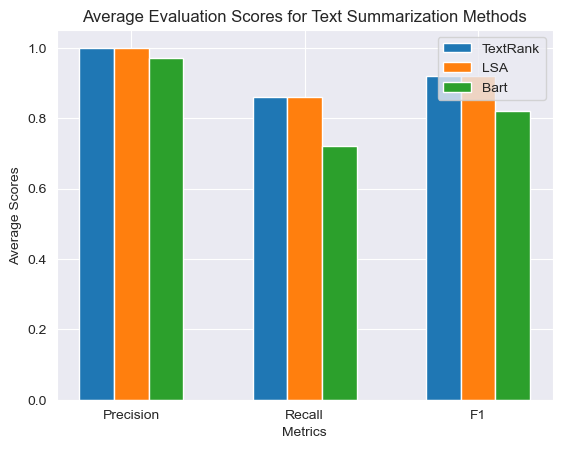

In [386]:
# Average scores for TextRank
tr_scores = [tr_p_average_rounded, tr_r_average_rounded, tr_f1_average_rounded]

# Average scores for LSA
lsa_scores = [lsa_p_average_rounded, lsa_r_average_rounded, lsa_f1_average_rounded]

# Average scores for Bart
bart_scores = [bart_p_average_rounded, bart_r_average_rounded, bart_f1_average_rounded]

# Metric names
metrics = ['Precision', 'Recall', 'F1']

# Bar width
bar_width = 0.2

# Set up positions for bars
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.bar(r1, tr_scores, width=bar_width, label='TextRank')
plt.bar(r2, lsa_scores, width=bar_width, label='LSA')
plt.bar(r3, bart_scores, width=bar_width, label='Bart')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Average Scores')
plt.title('Average Evaluation Scores for Text Summarization Methods')
plt.xticks([r + bar_width for r in range(len(metrics))], metrics)

# Add legend
plt.legend()

# Show the plot
plt.show()

# Skills identification using unsupervised ML: Word2Vec

In [70]:
#Load progress to create new data frame
job_tech_skills_df = pd.read_csv(r'job_df.csv')

In [384]:
display(job_tech_skills_df)

index                                                URL  \
0        0  https://www.seek.com.au/job/71826676?type=prom...   
1        1  https://www.seek.com.au/job/71667227?type=prom...   
2        2  https://www.seek.com.au/job/71795985?type=stan...   
3        3  https://www.seek.com.au/job/71662757?type=stan...   
4        4  https://www.seek.com.au/job/71836109?type=stan...   
..     ...                                                ...   
341    341  https://www.seek.com.au/job/71507589?type=stan...   
342    342  https://www.seek.com.au/job/71610316?type=stan...   
343    343  https://www.seek.com.au/job/71546073?type=stan...   
344    344  https://www.seek.com.au/job/71868849?type=stan...   
345    345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  \
0    Culture and Benefits:At Nexus, caring for our ...   
1    We are seeking a dedicated and detail-oriented...   
2    About UsWe’re an innovative and dynamic techno...   
3    Competitive salary package and employee benefi...   
4    A new role has become available for a mid to s...   
..                                                 ...   
341  We are currently tendering for works in Brisba...   
342  What if you could shape built and natural envi...   
343  Join our team of intelligent and collaborative...   
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Lo

#### Create new corpus for task

In [72]:
#Append features to creat corpus
job_tech_skills_df['Corpus_raw'] = (
    job_tech_skills_df['Job Title'].fillna('') +
    ' ' +
    job_tech_skills_df['Company'].fillna('') +
    ' ' +
    job_tech_skills_df['Location'].fillna('') +
    ' ' +
    job_tech_skills_df['Department'].fillna('') +
    ' ' +
    job_tech_skills_df['Position Type'].fillna('') +
    ' ' +
    job_tech_skills_df['Description'].fillna('')
)

display(job_tech_skills_df)

index                                                URL  \
0        0  https://www.seek.com.au/job/71826676?type=prom...   
1        1  https://www.seek.com.au/job/71667227?type=prom...   
2        2  https://www.seek.com.au/job/71795985?type=stan...   
3        3  https://www.seek.com.au/job/71662757?type=stan...   
4        4  https://www.seek.com.au/job/71836109?type=stan...   
..     ...                                                ...   
341    341  https://www.seek.com.au/job/71507589?type=stan...   
342    342  https://www.seek.com.au/job/71610316?type=stan...   
343    343  https://www.seek.com.au/job/71546073?type=stan...   
344    344  https://www.seek.com.au/job/71868849?type=stan...   
345    345  https://www.seek.com.au/job/71729288?type=stan...   

                                              Company  \
0                                Nexus Support Office   
1    Fleet Safety Services P/L TAS Minecorp Australia   
2                               Jumbo Interactive Ltd   
3                             Queensland Country Bank   
4                                     Humanised Group   
..                                                ...   
341                      Civil Services Group Pty Ltd   
342                         WSP Australia Pty Limited   
343                         WSP Australia Pty Limited   
344                                            Worley   
345                          Pfizer Australia Pty Ltd   

                       Location  \
0         Toowong, Brisbane QLD   
1    Acacia Ridge, Brisbane QLD   
2                  Brisbane QLD   
3                  Brisbane QLD   
4                  Brisbane QLD   
..                          ...   
341                Brisbane QLD   
342                Brisbane QLD   
343                Brisbane QLD   
344                Brisbane QLD   
345      Murarrie, Brisbane QLD   

                                            Department  \
0    Database Development & Administration (Informa...   
1    Business/Systems Analysts (Information & Commu...   
2    Team Leaders (Information & Communication Tech...   
3                         Other (Science & Technology)   
4    Database Development & Administration (Informa...   
..                                                 ...   
341        Health, Safety & Environment (Construction)   
342  Environmental, Earth & Geosciences (Science & ...   
343  Environmental, Earth & Geosciences (Science & ...   
344  Management (Manufacturing, Transport & Logistics)   
345                       Sales (Healthcare & Medical)   

                      Position Type                     Salary  \
0                     Contract/Temp  $120,000 + Super per year   
1                         Full time                        NaN   
2                         Full time                        NaN   
3                         Full time                        NaN   
4                         Full time              $145,000 base   
..                              ...                        ...   
341  Contract/Temp, Casual/Vacation                        NaN   
342                       Full time                        NaN   
343                       Full time                        NaN   
344                       Full time                        NaN   
345                       Full time                        NaN   

                                           Description  \
0    Culture and Benefits:At Nexus, caring for our ...   
1    We are seeking a dedicated and detail-oriented...   
2    About UsWe’re an innovative and dynamic techno...   
3    Competitive salary package and employee benefi...   
4    A new role has become available for a mid to s...   
..                                                 ...   
341  We are currently tendering for works in Brisba...   
342  What if you could shape built and natural envi...   
343  Join our team of intelligent and collaborative...   
344  Company: Worley\n:  AUS-QLD-Brisbane\n:  Lo

In [73]:
#Clean corpus
stop_words = set(stopwords.words('english'))

def text_preprocessing(uncleaned_text_corpus):
    lemmatizer = WordNetLemmatizer()
    corpus = []

    for i in range(0, len(uncleaned_text_corpus)):
        text = re.sub("\':", "", uncleaned_text_corpus[i])
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        
        # Tokenize the text
        words = word_tokenize(text)
        all_stopwords = set(stopwords.words('english'))
        
        # Lemmatize each word and remove stopwords
        words = [lemmatizer.lemmatize(word) for word in words if word not in all_stopwords]
        
        # Join the lemmatized words back into a sentence
        text = ' '.join(words)
        corpus.append(text)

    return corpus

In [158]:
#Apply text pre-processing
job_tech_skills_df['Corpus'] = text_preprocessing(job_tech_skills_df['Corpus_raw'])

#Compare raw vs processed corpus
display(job_tech_skills_df['Corpus_raw'][5])
display(job_tech_skills_df['Corpus'][5])

"Data Analyst Centacare Brisbane QLD Business/Systems Analysts (Information & Communication Technology) Full time The Organisation: \xa0\xa0 Centacare, an Agency of the Catholic Archdiocese of Brisbane, is a values-based organisation dedicated to providing services to the entire community, irrespective of religion, circumstance, ethnicity, economic situation, age, gender, or ability. With a workforce of over 3,000 employees and volunteers, Centacare operates in more than 200 locations, supporting tens of thousands of people each year across various Directorates. \xa0\xa0 The role: \xa0\xa0 We currently have an exciting career progression opportunity for the role of Data Analyst. This role will be a permanent full time position. The Data Analyst will play a pivotal role supporting Centacare Business Intelligence and Data Analytics program by providing timely and accurate insights for decision-making, ensuring data quality, collaborating with various teams to optimise data usage, and con

'data analyst centacare brisbane qld business system analyst information communication technology full time organisation centacare agency catholic archdiocese brisbane value based organisation dedicated providing service entire community irrespective religion circumstance ethnicity economic situation age gender ability workforce employee volunteer centacare operates location supporting ten thousand people year across various directorate role currently exciting career progression opportunity role data analyst role permanent full time position data analyst play pivotal role supporting centacare business intelligence data analytics program providing timely accurate insight decision making ensuring data quality collaborating various team optimise data usage contributing operational improvement key duty collaborate key stakeholder ensure accurate documentation planning efficient use data fostering continuous improvement compliance data governance policy follow change management process incl

#### Implement Word2Vec to find  semantically related words to the initial word set

In [240]:
corpus = job_tech_skills_df['Corpus'].apply(word_tokenize).tolist()

# Define and train the Word2Vec model
word2vec_model = Word2Vec(sentences=corpus, vector_size=1000, window=50, min_count=1, workers=4)

# Save the trained model to a file for future use
word2vec_model.save("word2vec_model.bin")

# Get the vector for each skill
python_vector = word2vec_model.wv['python']
sql_vector = word2vec_model.wv['sql']
azure_vector = word2vec_model.wv['azure']
power_bi_vector = word2vec_model.wv['powerbi']
tableau_vector = word2vec_model.wv['tableau']
boomi_vector = word2vec_model.wv['boomi']

# Find similar words for each skill
similar_python = word2vec_model.wv.most_similar('python', topn=30)
similar_sql = word2vec_model.wv.most_similar('sql', topn=30)
similar_azure = word2vec_model.wv.most_similar('azure', topn=30)
similar_power_bi = word2vec_model.wv.most_similar('powerbi', topn=30)
similar_ability = word2vec_model.wv.most_similar('tableau', topn=30)
similar_boomi = word2vec_model.wv.most_similar('boomi', topn=30)

# Print the results which display associated words and their cosine similarities to the searched word
display("Similar words for Python:", similar_python)
display("Similar words for SQL:", similar_sql)
display("Similar words for Azure:", similar_azure)
display("Similar words for Power BI:", similar_power_bi)
display("Similar words for Tableau:", similar_ability)
display("Similar words for Boomi:", similar_boomi)

'Similar words for Python:'

[('javascript', 0.9973601698875427),
 ('language', 0.9964205026626587),
 ('qgis', 0.9962319135665894),
 ('server', 0.9956175088882446),
 ('snowflake', 0.9955861568450928),
 ('devops', 0.9954691529273987),
 ('cd', 0.9953227043151855),
 ('basic', 0.9947769045829773),
 ('solid', 0.9946579337120056),
 ('tight', 0.9940891861915588),
 ('preferredexperience', 0.9939552545547485),
 ('e', 0.9938687086105347),
 ('negotiation', 0.9936347603797913),
 ('structure', 0.9927048683166504),
 ('relational', 0.9923866391181946),
 ('arcgis', 0.9923455715179443),
 ('certification', 0.9916998744010925),
 ('concept', 0.9916917681694031),
 ('modality', 0.9915767908096313),
 ('powerbi', 0.9905945062637329),
 ('convey', 0.9905562996864319),
 ('preferably', 0.9904319047927856),
 ('gcp', 0.9902414083480835),
 ('complementary', 0.9902288317680359),
 ('sql', 0.9902160167694092),
 ('sharepoint', 0.9897642731666565),
 ('useful', 0.9895018339157104),
 ('java', 0.9893609285354614),
 ('ci', 0.9891900420188904),
 ('dilige

'Similar words for SQL:'

[('basic', 0.9985896348953247),
 ('lifecycles', 0.9981203675270081),
 ('thorough', 0.9979456067085266),
 ('proficiency', 0.9976910352706909),
 ('java', 0.9964137077331543),
 ('preferably', 0.9955279231071472),
 ('ba', 0.9949548244476318),
 ('language', 0.9947662949562073),
 ('familiarity', 0.994640052318573),
 ('visual', 0.994473934173584),
 ('snowflake', 0.9941585063934326),
 ('concept', 0.9940155744552612),
 ('negotiation', 0.9939649701118469),
 ('qlik', 0.9936636686325073),
 ('problem', 0.9926787614822388),
 ('etc', 0.9922475218772888),
 ('uml', 0.9922154545783997),
 ('server', 0.9921433329582214),
 ('javascript', 0.9919094443321228),
 ('administering', 0.9912976622581482),
 ('linux', 0.9911638498306274),
 ('convey', 0.991055965423584),
 ('solid', 0.9909526109695435),
 ('kg', 0.9906899333000183),
 ('python', 0.9902160167694092),
 ('mediate', 0.9901875853538513),
 ('diligence', 0.9901840686798096),
 ('proficient', 0.9901514649391174),
 ('modality', 0.9900721907615662),
 ('web', 0.988

'Similar words for Azure:'

[('analytical', 0.9983357787132263),
 ('related', 0.9970855712890625),
 ('artefact', 0.9968997240066528),
 ('understanding', 0.9956322312355042),
 ('programming', 0.9954721927642822),
 ('translate', 0.9941518902778625),
 ('coding', 0.9941037893295288),
 ('native', 0.993752121925354),
 ('ba', 0.9933949708938599),
 ('visualisation', 0.9927427768707275),
 ('dependency', 0.992722749710083),
 ('bi', 0.992024838924408),
 ('facilitation', 0.9916731119155884),
 ('hana', 0.9916055202484131),
 ('object', 0.9912401437759399),
 ('using', 0.9911824464797974),
 ('linux', 0.990921139717102),
 ('lifecycles', 0.9905099868774414),
 ('workflow', 0.9900815486907959),
 ('advanced', 0.9894932508468628),
 ('proficiency', 0.9894579648971558),
 ('currency', 0.9893953204154968),
 ('microsoft', 0.9891275763511658),
 ('correction', 0.9886780977249146),
 ('transact', 0.9886412024497986),
 ('motivating', 0.9886385798454285),
 ('desireable', 0.9885785579681396),
 ('acumen', 0.9885314106941223),
 ('problem', 0.988108

'Similar words for Power BI:'

[('iso', 0.9976269602775574),
 ('qgis', 0.9973956346511841),
 ('eager', 0.9970704317092896),
 ('arcgis', 0.9969400763511658),
 ('gi', 0.9964368939399719),
 ('devops', 0.9953818917274475),
 ('linq', 0.9949648976325989),
 ('layer', 0.9944753646850586),
 ('e', 0.9944609999656677),
 ('tfs', 0.9939210414886475),
 ('pyspark', 0.9934013485908508),
 ('gitlab', 0.9933702349662781),
 ('automating', 0.9932277798652649),
 ('react', 0.9932108521461487),
 ('findingspresentations', 0.9929190278053284),
 ('gcp', 0.9927881360054016),
 ('audience', 0.9927638173103333),
 ('applied', 0.9927346706390381),
 ('oriented', 0.9926779270172119),
 ('anylogiccompile', 0.992581844329834),
 ('preferredexperience', 0.9924483895301819),
 ('moderately', 0.9923673272132874),
 ('computing', 0.9922254085540771),
 ('knowledgeable', 0.9920838475227356),
 ('succeed', 0.9920240044593811),
 ('equator', 0.9919943809509277),
 ('mindset', 0.9915809631347656),
 ('moderate', 0.9915483593940735),
 ('sharepoint', 0.9915213584899902),

'Similar words for Tableau:'

[('manual', 0.9992193579673767),
 ('interface', 0.9984316825866699),
 ('kimball', 0.9982525706291199),
 ('understandable', 0.9979240298271179),
 ('repository', 0.9970317482948303),
 ('automating', 0.9968862533569336),
 ('artifactory', 0.9966591596603394),
 ('pl', 0.9962365031242371),
 ('google', 0.9962219595909119),
 ('knowledgeable', 0.9959854483604431),
 ('item', 0.9959580302238464),
 ('ftp', 0.9957262277603149),
 ('dataverse', 0.9957228899002075),
 ('oriented', 0.9955198764801025),
 ('vault', 0.9950666427612305),
 ('log', 0.9948440790176392),
 ('etl', 0.9947141408920288),
 ('datasets', 0.9946948289871216),
 ('processing', 0.9946386814117432),
 ('mixture', 0.9944994449615479),
 ('ci', 0.9943566918373108),
 ('mstest', 0.9941338300704956),
 ('skillsexperience', 0.9941132664680481),
 ('flow', 0.9939460158348083),
 ('alerting', 0.9937217831611633),
 ('frontend', 0.993634045124054),
 ('analytic', 0.9935203790664673),
 ('analysiswe', 0.9934152960777283),
 ('internally', 0.9933114051818848)

'Similar words for Boomi:'

[('pentaho', 0.9977512359619141),
 ('threading', 0.9967346787452698),
 ('async', 0.9964637160301208),
 ('net', 0.9963051676750183),
 ('alerting', 0.9962112903594971),
 ('frontend', 0.9957265853881836),
 ('microservice', 0.9956804513931274),
 ('roll', 0.9952251315116882),
 ('log', 0.9951478242874146),
 ('restful', 0.9949001669883728),
 ('etl', 0.9948581457138062),
 ('messaging', 0.9946866035461426),
 ('processing', 0.9946308732032776),
 ('gmp', 0.9946282505989075),
 ('identification', 0.9944522380828857),
 ('hts', 0.994135856628418),
 ('flow', 0.9940630197525024),
 ('pattern', 0.9939524531364441),
 ('elasticsearch', 0.9936280846595764),
 ('defect', 0.9935880899429321),
 ('profileyou', 0.9930764436721802),
 ('appealing', 0.9930061101913452),
 ('terraform', 0.9929711222648621),
 ('manual', 0.992968738079071),
 ('tableau', 0.9929680824279785),
 ('backend', 0.9927403330802917),
 ('understandable', 0.992718517780304),
 ('kimball', 0.9925411939620972),
 ('interface', 0.9919123649597168),
 ('w

#### Create list of Data Science technical skills based on domain knowledge and Word2Vec results

In [378]:
#Craete Data Science technical skills list based on Word2Vec and domain knowledge
data_science_skills = ['python', 'sql', 'machine learning', 'data analysis', 'data visualization', 'azure', 'power bi', 'deep learning', 'devops', 'linux', 'javascript', 'web development', 'oracle', 'snowflake', 'git', 'analytics', 'gcp', 'analytical skills', 'bi', 'qgis', 'boomi', 'tableau', 'devops', 'programming', 'qlik', 'scada', 'aws', 'jenkins', 'waterfall', 'transact', 'gitlab', 'frontend', 'backend', 'database', 'sharepoint', 'qlik', 'llm', 'uml','linq', 'tensorflow', 'pyspark', 'mstest', 'pentaho']


#### Conduct trend analysis

In [379]:
# Search for occurrences of skills in the corpus
for skill in data_science_skills:
    job_tech_skills_df[skill] = job_tech_skills_df['Corpus'].str.contains(skill, case=False)

In [385]:
# Rank the skills based on frequency
skill_frequency = job_tech_skills_df[data_science_skills].sum().sort_values(ascending=False)

# Convert to DataFrame
skills_df = pd.DataFrame({'Skills': skill_frequency.index, 'Frequency': skill_frequency.values})

# Display the ranked skills DataFrame
display(skills_df)


Skills  Frequency
0                   bi        340
1            analytics         81
2                  git         80
3             database         71
4                  sql         63
5        data analysis         62
6               python         50
7          programming         45
8                azure         39
9             power bi         29
10                 aws         23
11              devops         19
12              devops         19
13    machine learning         17
14             tableau         16
15                 llm         10
16           snowflake          8
17          javascript          7
18             backend          6
19          sharepoint          5
20            frontend          5
21               linux          5
22            transact          5
23               boomi          4
24                qgis          4
25                linq          4
26              mstest          4
27                qlik          4
28              oracle          4
29                 gcp          4
30              gitlab          4
31                qlik          4
32  data visualization          3
33             pyspark          3
34           waterfall          3
35             jenkins          3
36   analytical skills          2
37                 uml          2
38               scada          2
39          tensorflow          2
40     web development          1
41       deep learning          1
42             pentaho          1

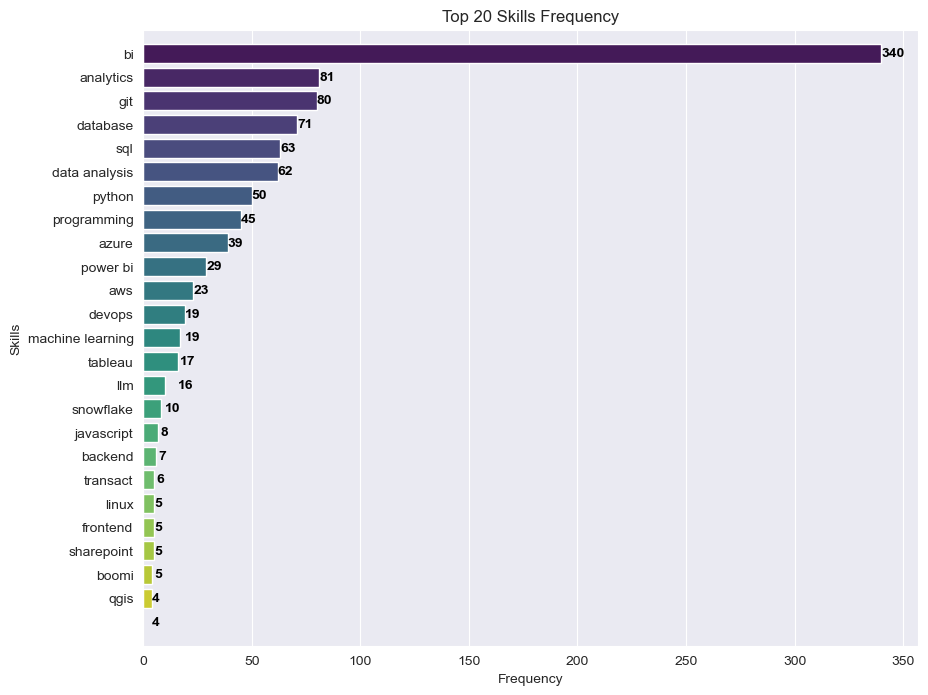

In [381]:
# Sort the skills_df in descending order
skills_df = skills_df.sort_values(by='Frequency', ascending=False)

# Select the top 20 skills
top_skills_df = skills_df.head(25)

# Plot the horizontal bar chart for the top 20 skills
plt.figure(figsize=(10, 8))
barplot = sns.barplot(x='Frequency', y='Skills', data=top_skills_df, palette='viridis')
plt.title('Top 20 Skills Frequency')
plt.xlabel('Frequency')

# Add data labels on the right of the bars
for index, value in enumerate(top_skills_df['Frequency']):
    plt.text(value, index, str(value), ha='left', va='center', color='black', fontweight='bold')

# Set y-axis limits to reverse the order
plt.ylim(len(top_skills_df), -1)

plt.show()


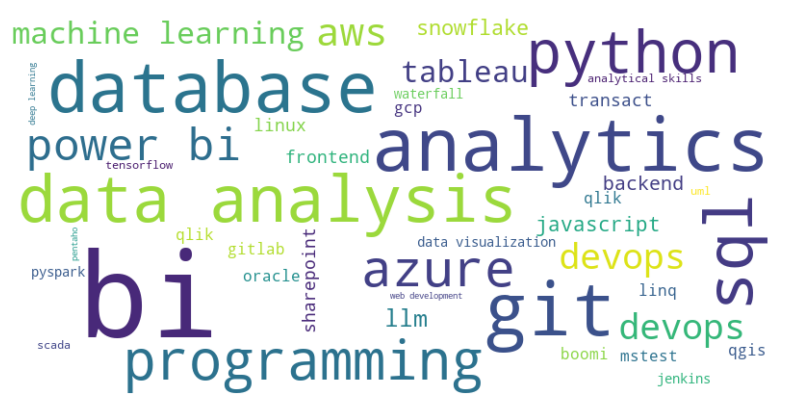

In [382]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(skill_frequency)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()